In [38]:
from bs4 import BeautifulSoup as bsoup
import urllib.robotparser
import requests
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle5 as pickle
import re
import pprint
pp = pprint.PrettyPrinter(indent=4)

## Data Collection / Web Scraping

In [ ]:
# DATA COLLECTION

# First scrape daily box office info for all movies in theaters from boxofficemojo.com

# Build date for URL and make requests for each day from 2015-2019
month_and_days = {'01': [x for x in range(1,32)], '02': [x for x in range(1,29)], '03':[x for x in range(1,32)],
                  '04':[x for x in range(1,31)],'05':[x for x in range(1,32)], '06':[x for x in range(1,31)], 
                 '07':[x for x in range(1,32)], '08':[x for x in range(1,32)], '09':[x for x in range(1,31)],
                 '10': [x for x in range(1,32)], '11':[x for x in range(1,31)], '12':[x for x in range(1,32)]}

leap_years = [2008, 2016, 2020]
leap_year_month_days = {'01': [x for x in range(1,32)], '02': [x for x in range(1,30)], '03':[x for x in range(1,32)],
                  '04':[x for x in range(1,31)],'05':[x for x in range(1,32)], '06':[x for x in range(1,31)], 
                 '07':[x for x in range(1,32)], '08':[x for x in range(1,32)], '09':[x for x in range(1,31)],
                 '10': [x for x in range(1,32)], '11':[x for x in range(1,31)], '12':[x for x in range(1,32)]}

all_data = []

for year in range(2015, 2020):
    # build url for each year-month-day and scrape table data
    url = 'https://www.boxofficemojo.com/date/'
    
    if year in leap_years:
        m_d = leap_year_month_days
    else:
        m_d = month_and_days
        
    y = str(year)
    
    for month in m_d:
        m = '-' + month
        for day in m_d[month]:
            if len(str(day)) == 1:
                d = '-' + '0' + str(day)
            else:
                d = '-' + str(day)
            
            date = y + m + d
            url_curr = url + date
            
            #get data
            page = requests.get(url_curr)
            soup = bsoup(page.text, 'lxml')
            
            all_divs = soup.main.find_all("div", id="table")
            
            try:
                all_tables = all_divs[0].find_all("table")
            except:
                print(date)
            
            try:
                all_trs = all_tables[0].find_all("tr")
            except:
                print(date)
            
            for i in range(1, len(all_trs)):

                all_tds = all_trs[i].find_all("td")
                a_href = all_tds[2].find('a',href=True)
                a_href = 'http://boxofficemojo.com' + a_href['href']
                entry = []

                for j in range(0, len(all_tds)):
                    entry.append(all_tds[j].text)       
                
                entry = entry[0:11]
                entry.append(a_href)
                entry.append(date)

                # append row data to all_data list
                all_data.append(entry)
    print(f'{year} processed...')

In [ ]:
# Create data frame from all_data and save to pickle
column_names = ['TD', 'YD', 'Movie', 'Daily', '%YD', '%LW', 'Theaters', 'Avg', 'To_Date', 
                'Days', 'Distributor', 'href','Date']
df = pd.DataFrame(all_data, columns=column_names)
df.to_pickle('boxofficemojo-daily_gross.pkl')
df

** Reload original box office gross pkl in here

In [ ]:
# read data back in
df = pd.read_pickle('boxofficemojo-daily_gross.pkl')

In [ ]:
# Make a list of unique titles
titles_unique = list(set(df['Movie']))

# Go to each movie page to scrape genre data and add to dataframe
genre_dict = {}

for m in titles_unique:
    h = list(df.loc[df['Movie'] == m, 'href'])[0]
    movie_page = requests.get(h)
    movie_soup = bsoup(movie_page.text, 'lxml')

    table_div = movie_soup.find('div', {'class': 'mojo-summary-values'})
    sub_divs = table_div.find_all('div')

    for s in sub_divs:
        if re.search('^Genres',s.text):
            genres = s.text
            genres = re.sub('Genres', '', genres)
            genres = re.sub('\s+', ' ', genres)
    genre_dict[m] = genres.split()

genre_dict

In [ ]:
# For each movie in the dictionary, unpack genres into string and add to genre column for that film
for m in genre_dict:
    genres = genre_dict[m]
    genre_str = ''
    for g in genres:
        genre_str += g + '|'
    df.loc[df['Movie'] == m,'genre'] = genre_str

df.genre.sample(5)

In [ ]:
# Split the genres into their own columns with True/False values
unique_genre =  df.genre.str.split('|').sum()
unique_genre = set(unique_genre)
unique_genre

for g in unique_genre:
    df[g] = df.genre.map( lambda x: g in x.split('|') )
    
df.sample(10)

In [ ]:
# Replace non-numeric values for numeric data columns
df['Daily'] = df['Daily'].str.replace('[^0-9]', '')
df['To_Date'] = df['To_Date'].str.replace('[^0-9]', '')
df['%YD'] = df['%YD'].str.replace('+', '')
df['%YD'] = df['%YD'].str.replace('-', '')
df['%YD'] = df['%YD'].str.replace('%', '')
df['%YD'] = df['%YD'].str.replace(',', '')
df['%YD'] = df['%YD'].str.replace('<0.1', '0')
df['%LW'] = df['%LW'].str.replace('+', '')
df['%LW'] = df['%LW'].str.replace('-', '')
df['%LW'] = df['%LW'].str.replace('%', '')
df['%LW'] = df['%LW'].str.replace(',', '')
df['%LW'] = df['%LW'].str.replace('<0.1', '0')
df['Theaters'] = df['Theaters'].str.replace('[^0-9]', '')
df['Avg'] = df['Avg'].str.replace('[^0-9]', '')
df['Days'] = df['Days'].str.replace('[^0-9]', '')
df['Distributor'] = df['Distributor'].str.replace('\\n', '')

# Update data types
df['Daily'] = pd.to_numeric(df['Daily'])
df['%YD'] = pd.to_numeric(df['%YD'])
df['%LW'] = pd.to_numeric(df['%LW'])
df['Theaters'] = pd.to_numeric(df['Theaters'])
df['Avg'] = pd.to_numeric(df['Avg'])
df['To_Date'] = pd.to_numeric(df['To_Date'])
df['Days'] = pd.to_numeric(df['Days'])
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

In [ ]:
df.sample(10)

In [ ]:
# Send data to pickle
df.to_pickle('clean-boxofficemojo-daily_gross.pkl')

In [ ]:
## LABOR STATISTICS

# Scrape data from the US Bureau of Labor Statistics
# Consumer prices increase 5.0 percent for the year ended May 2021
url = "https://www.bls.gov/opub/ted/2021/consumer-prices-increase-5-0-percent-for-the-year-ended-may-2021.htm"
page = requests.get(url)
soup = bsoup(page.text, 'lxml')

In [ ]:
all_tables = soup.find_all("table", class_="regular")
headers = all_tables[0].find('thead').text.strip().split("\n")
headers

all_rows = []

tbody = all_tables[0].find('tbody')
entries = tbody.find_all('tr')

for i in entries:
    x = i.text.strip().split("\n")
    x = x[0:1] + x[2:]
    all_rows.append(x)

all_dat = pd.DataFrame(all_rows, columns=headers)
all_dat['Month'] = pd.to_datetime(all_dat['Month'])
all_dat = all_dat.replace('%','', regex=True)

heads = all_dat.columns[1:]
for item in heads:
    all_dat[item] = pd.to_numeric(all_dat[item])
    
all_dat.to_pickle("final-clean-consumer_prices.pkl")
all_dat.to_csv("final-clean-consumer_prices.csv")
all_dat

In [ ]:
# Real average weekly earnings down 2.2 percent from May 2020 to May 2021
url = "https://www.bls.gov/opub/ted/2021/real-average-weekly-earnings-down-2-2-percent-from-may-2020-to-may-2021.htm"
page = requests.get(url)
soup = bsoup(page.text, 'lxml')

In [ ]:
all_tables = soup.find_all("table", class_="regular")
headers = all_tables[0].find('thead')
heads = headers.find_all('tr')
head = ["Month"] + heads[1].text.strip().split("\n")
head

all_rows = []

tbody = all_tables[0].find('tbody')
entries = tbody.find_all('tr')

for i in entries:
    x = i.text.strip().split("\n")
    x = x[0:1] + x[2:]
    all_rows.append(x)

all_dat = pd.DataFrame(all_rows, columns=head)
all_dat['Month'] = pd.to_datetime(all_dat['Month'])
all_dat = all_dat.replace('\$','', regex=True)
all_dat = all_dat.replace('%','', regex=True)

heads = all_dat.columns[1:]
for item in heads:
    all_dat[item] = pd.to_numeric(all_dat[item])
    
all_dat.to_pickle("final-clean-weekly_earnings.pkl")
all_dat.to_csv("final-clean-weekly_earnings.csv")
all_dat

## Merging Datasets

** Reload clean box office gross in here

In [ ]:
## Merge Datasets

with open('clean-boxofficemojo-daily_gross.pkl', "rb") as fh:
  dat = pickle.load(fh)


df = dat[['Date', 'Movie', 'Daily', 'Theaters', 'Avg',
       'To_Date', 'Days', 'Distributor', 'genre', 'Music',
       'Short', 'Family', 'Horror', 'Crime', 'Documentary', 'News', 'Musical',
       'History', 'Western', 'War', 'Comedy', 'Thriller', 'Action', 'Romance',
       'Biography', 'Sport', 'Sci-Fi', 'Drama', 'Fantasy', 'Animation',
       'Mystery', 'Adventure', 'Film-Noir', 'Adult']]
df = df.dropna()
col = df.columns.tolist()

# mutiply genre by daily to dispay total revenue per genre 
for i in range(9, len(col)):
    df[col[i]] = df[col[i]]*df['Daily']
    
# This is the main raw movie DF
df.head()

In [ ]:
# create month column and group movie data by month
df['Month'] = df['Date'].apply(lambda x: x.strftime('%Y-%m'))

df = df.groupby(['Month']).agg({'Music':'sum',
                             'Short':'sum',
                             'Family':'sum',
                             'Horror':'sum',
                             'Crime':'sum',
                             'Documentary':'sum',
                             'News':'sum',
                             'Musical':'sum',
                             'History':'sum',
                             'Western':'sum',
                             'War':'sum',
                             'Comedy':'sum',
                             'Thriller':'sum',
                             'Action':'sum',
                             'Romance':'sum',
                             'Biography':'sum',
                             'Sport':'sum',
                             'Sci-Fi':'sum',
                             'Drama':'sum',
                             'Fantasy':'sum',
                             'Animation':'sum',
                             'Mystery':'sum',
                             'Adventure':'sum',
                             'Film-Noir':'sum',
                             'Adult':'sum'}).round(2)
df.sample(10)

In [ ]:
# create new DF Genre that has all the info from the original df 
genre = df.reset_index()

# make month date time
genre['Month'] = pd.to_datetime(genre['Month'])

# read and display economic data
cp = pd.read_pickle('final-clean-consumer_prices.pkl')
we = pd.read_pickle('final-clean-weekly_earnings.pkl')
print(genre.columns)
print(cp.columns)
print(we.columns)
genre.dtypes

In [ ]:
#merge all movie and economic data, save as pkl
alldat = pd.merge(genre, cp, how='left', left_on='Month', right_on='Month')
alldat = pd.merge(alldat, we, how='left', left_on='Month', right_on='Month')

alldat.to_pickle('alldat.pkl')

** RELOAD FULL DATASET HERE

In [108]:
# reload the alldat pickle and store in df
# with open('alldat.pkl', "rb") as fh:
#   df = pickle.load(fh)

df = pd.read_pickle('alldat.pkl')

df

,Month,Music,Short,Family,Horror,Crime,Documentary,News,Musical,History,...,Furniture and bedding,Apparel,Used cars and trucks,Medical care,Sporting goods,Public transportation,Average weekly earnings of all employees,12-month percent change in average weekly earnings of all employees,"Real average weekly earnings of all employees, 1982-1984 dollars",12-month percent change in real average weekly earnings of all employees
0,2015-01-01,100133,184421,147664166,26149007,128172568,1427351,0,99391382,46149865,...,-2.2,-1.4,-4.0,2.6,-1.9,-1.8,853.19,2.4,363.45,2.7
1,2015-02-01,1159,225958,165612393,8478090,23401110,443213,0,6757431,7938838,...,-1.5,-0.8,-2.9,2.3,-1.9,-1.9,857.39,2.8,364.32,2.9
2,2015-03-01,417215,319151,244943697,22254918,143521226,595856,0,251500,1734157,...,-0.7,-0.5,-1.3,2.5,-2.2,-3.3,856.98,2.2,363.16,2.2
3,2015-04-01,4750771,261289,181627844,36005673,103680241,11874095,0,18568,33521281,...,0.0,-0.8,-0.5,2.9,-2.2,-4.7,858.71,2.3,363.52,2.4
4,2015-05-01,148344017,283589,110568094,45282366,59902335,4855223,0,804,14530889,...,-0.8,-1.5,-0.5,2.8,-2.0,-4.1,861.12,2.3,363.34,2.3
5,2015-06-01,44392751,217866,251297017,58912266,17427184,305391,0,0,2486271,...,-1.0,-1.8,-0.7,2.5,-2.2,-3.2,861.81,2.2,362.63,2.0
6,2015-07-01,72051633,211639,433218665,25313337,310374873,3042611,0,0,912307,...,-0.4,-1.6,-1.1,2.5,-0.9,-3.1,862.85,2.2,362.49,1.9
7,2015-08-01,162876889,184973,91882081,20310243,86003941,382722,0,0,135540579,...,-0.9,-0.9,-1.5,2.5,-0.9,-2.9,865.95,1.9,363.79,1.7
8,2015-09-01,29943790,34958,85844974,122913338,69229119,534570,0,0,27702764,...,0.2,-1.4,-1.7,2.5,-1.2,-2.9,866.30,2.2,364.76,2.2
9,2015-10-01,6523446,0,186594472,207490530,56673423,2549757,0,1650000,54645592,...,-0.5,-1.9,-1.4,3.0,-1.7,-2.3,871.92,2.5,366.76,2.4


## Visualizing the data

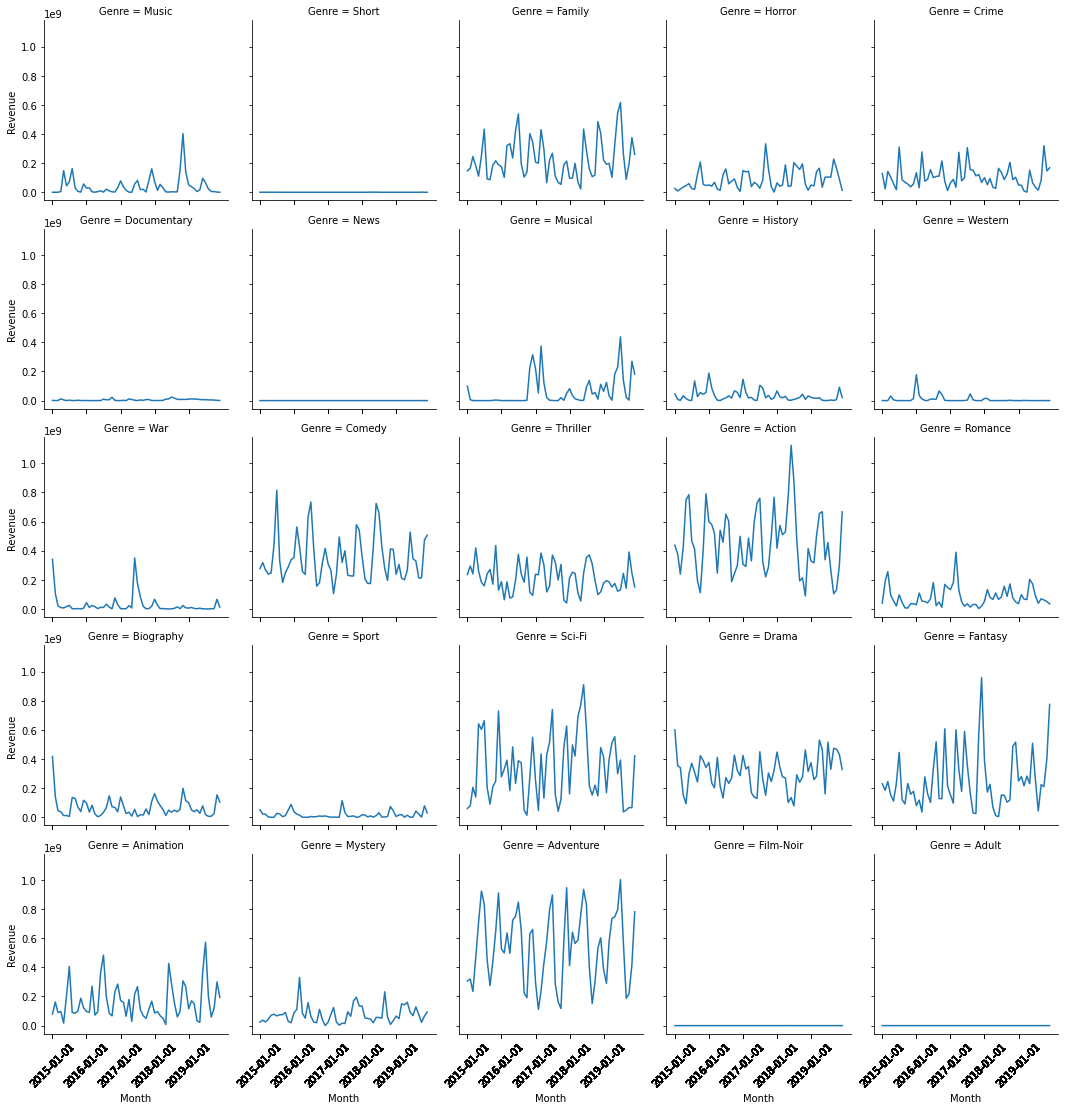

In [112]:
# create new data frame with only movie data to show the monthly revenue trends over time

cf = df[['Month', 'Music', 'Short', 'Family', 'Horror', 'Crime', 'Documentary',
       'News', 'Musical', 'History', 'Western', 'War', 'Comedy', 'Thriller',
       'Action', 'Romance', 'Biography', 'Sport', 'Sci-Fi', 'Drama', 'Fantasy',
       'Animation', 'Mystery', 'Adventure', 'Film-Noir', 'Adult']]

# melt data so the genre is categorical variable and revenue is the value 
cf = pd.melt(cf, id_vars=['Month'], value_vars=['Music', 'Short', 'Family', 'Horror', 'Crime', 'Documentary',
       'News', 'Musical', 'History', 'Western', 'War', 'Comedy', 'Thriller',
       'Action', 'Romance', 'Biography', 'Sport', 'Sci-Fi', 'Drama', 'Fantasy',
       'Animation', 'Mystery', 'Adventure', 'Film-Noir', 'Adult'],
        var_name='Genre', value_name='Revenue')



g = sns.FacetGrid(cf, col="Genre", col_wrap=5, height=3)
g.map(sns.lineplot, "Month", "Revenue", )
g.set(xticks=cf.Month[0::12])
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

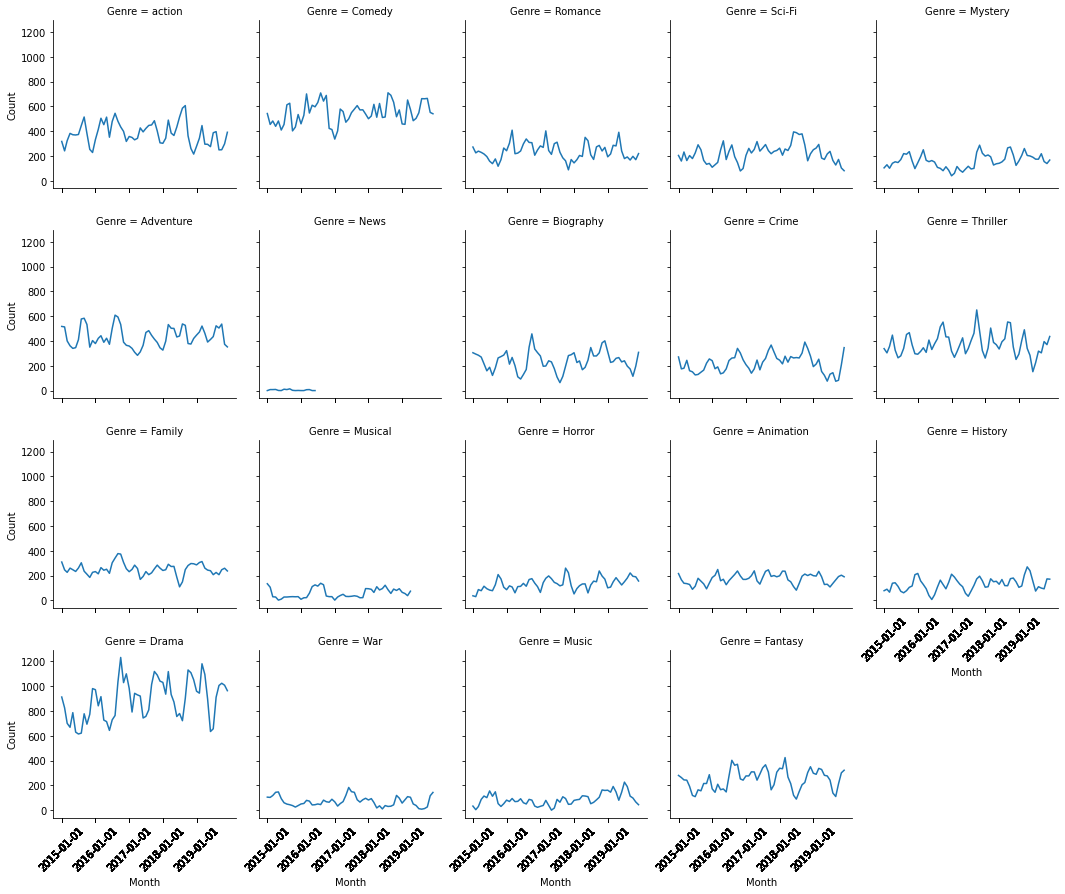

In [96]:
# making a facetgrid with count values instead of revenue

df_count = pd.read_pickle('econ_count_data.pkl')
count = df_count.reset_index()
count = count[['Month','action', 'Comedy', 'Romance', 'Sci-Fi', 'Mystery',
       'Adventure', 'News', 'Biography', 'Crime', 'Thriller',
       'Family', 'Musical', 'Horror', 'Animation', 'History', 'Drama',
       'War', 'Music', 'Fantasy']]

count = pd.melt(count, id_vars=['Month'], value_vars=['action', 'Comedy', 'Romance', 'Sci-Fi', 'Mystery',
       'Adventure', 'News', 'Biography', 'Crime', 'Thriller',
       'Family', 'Musical', 'Horror', 'Animation', 'History', 'Drama',
       'War', 'Music', 'Fantasy', ],
        var_name='Genre', value_name='Count')



g = sns.FacetGrid(count, col="Genre", col_wrap=5, height=3)
g.map(sns.lineplot, "Month", "Count")
g.set(xticks=count.Month[0::12])
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

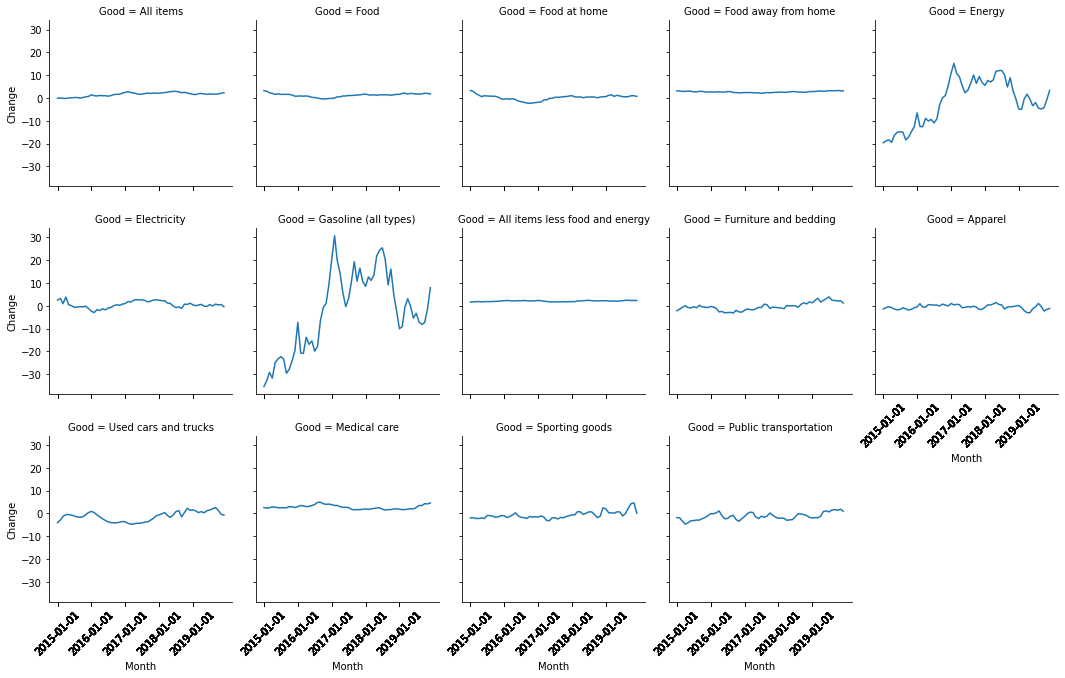

In [111]:
# now do the same witht the price data only
cf = df[['Month', 'All items', 'Food', 'Food at home', 'Food away from home',
       'Energy', 'Electricity', 'Gasoline (all types)',
       'All items less food and energy', 'Furniture and bedding', 'Apparel',
       'Used cars and trucks', 'Medical care', 'Sporting goods',
       'Public transportation']]

cf = pd.melt(cf, id_vars=['Month'], value_vars=['All items', 'Food', 'Food at home', 'Food away from home',
       'Energy', 'Electricity', 'Gasoline (all types)',
       'All items less food and energy', 'Furniture and bedding', 'Apparel',
       'Used cars and trucks', 'Medical care', 'Sporting goods',
       'Public transportation'],
        var_name='Good', value_name='Change')



g = sns.FacetGrid(cf, col="Good", col_wrap=5, height=3)
g.map(sns.lineplot, "Month", "Change")
g.set(xticks=cf.Month[0::12])
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

/Users/shelleysims/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


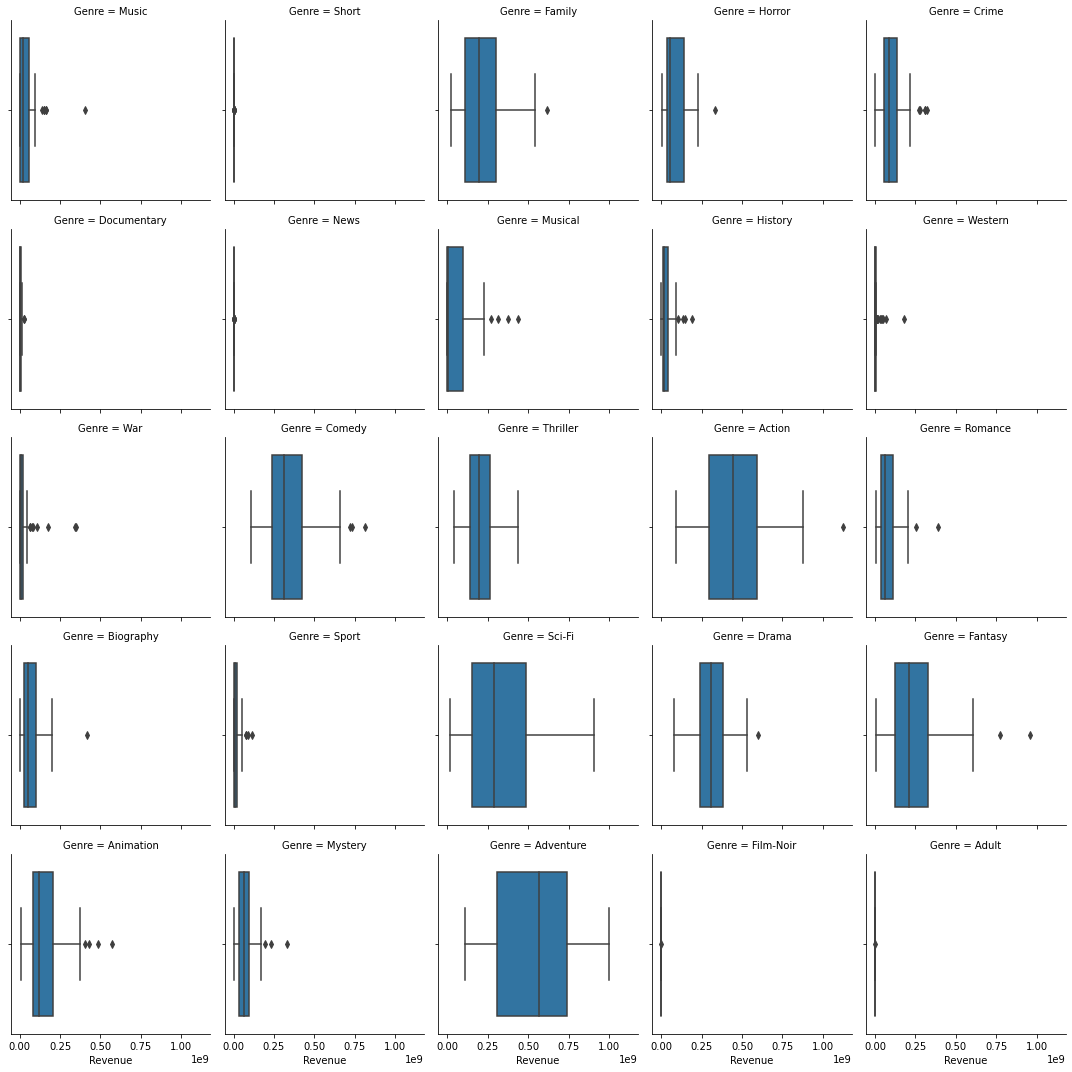

In [113]:
# plot box plots to check for major outliers
g = sns.FacetGrid(cf, col="Genre", col_wrap=5, height=3)
g.map(sns.boxplot, "Revenue")

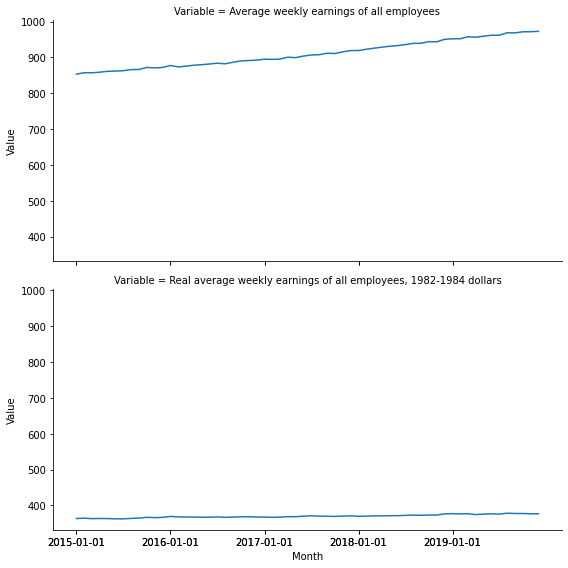

In [9]:
# Visualize trends in the data

# trend data for weekly earnings part 1
cf = df[['Month', 'Average weekly earnings of all employees',
       'Real average weekly earnings of all employees, 1982-1984 dollars']]

cf = pd.melt(cf, id_vars=['Month'], value_vars=['Average weekly earnings of all employees',
       'Real average weekly earnings of all employees, 1982-1984 dollars'],
        var_name='Variable', value_name='Value')



g = sns.FacetGrid(cf, row="Variable", height=4, aspect=2)
g.map(sns.lineplot, "Month", "Value")
g.set(xticks=cf.Month[0::12]);

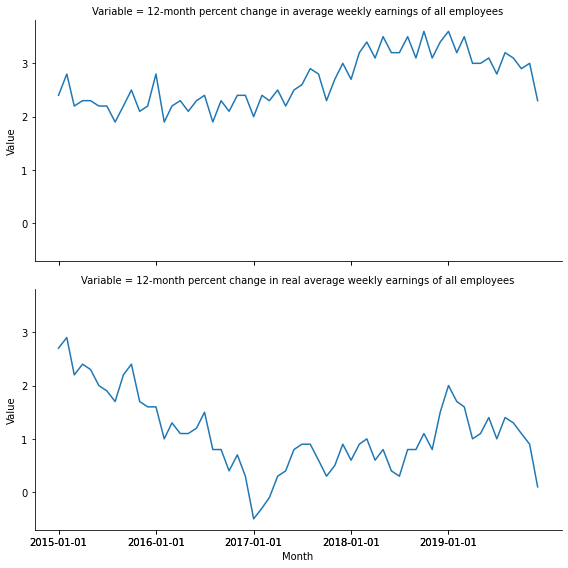

In [10]:
# trend data for weekly earnings part 1 (percentages)
cf = df[['Month', '12-month percent change in average weekly earnings of all employees',
       '12-month percent change in real average weekly earnings of all employees']]

cf = pd.melt(cf, id_vars=['Month'], value_vars=['12-month percent change in average weekly earnings of all employees',
       '12-month percent change in real average weekly earnings of all employees'],
        var_name='Variable', value_name='Value')



g = sns.FacetGrid(cf, row="Variable", height=4, aspect=2)
g.map(sns.lineplot, "Month", "Value")
g.set(xticks=cf.Month[0::12]);

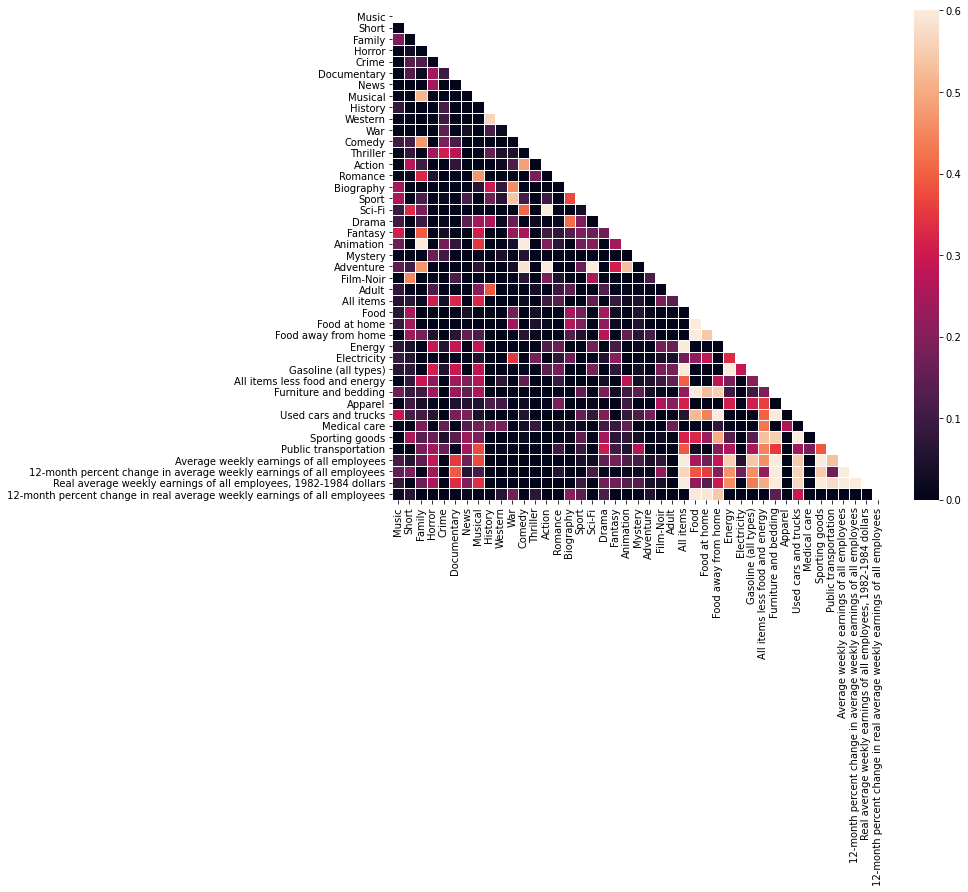

In [13]:
# Compute the correlation matrix
corr = df.corr()


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))


sns.heatmap(corr, mask=mask, vmin=0, vmax=.6,
            linewidths=.5);

In [159]:
df_count = pd.read_pickle('econ_count_data.pkl')
df_count.drop(['Adult', 'Film-Noir'], axis=1, inplace=True)
df_count.head()

,Month,action,Comedy,Romance,Sci-Fi,Mystery,Documentary,Adventure,News,Biography,...,Energy,Electricity,Gasoline (all types),All items less food and energy,Furniture and bedding,Apparel,Used cars and trucks,Medical care,Sporting goods,Public transportation
0,2015-01-01,318,543,273,205,105,100,518,1.0,306,...,-19.6,2.5,-35.4,1.6,-2.2,-1.4,-4.0,2.6,-1.9,-1.8
1,2015-02-01,242,455,226,160,130,85,514,9.0,295,...,-18.8,3.2,-32.8,1.7,-1.5,-0.8,-2.9,2.3,-1.9,-1.9
2,2015-03-01,324,483,240,233,102,108,401,9.0,286,...,-18.3,0.9,-29.2,1.8,-0.7,-0.5,-1.3,2.5,-2.2,-3.3
3,2015-04-01,383,440,230,164,142,145,362,10.0,271,...,-19.4,3.8,-31.7,1.8,0.0,-0.8,-0.5,2.9,-2.2,-4.7
4,2015-05-01,372,483,217,204,154,137,341,2.0,217,...,-16.3,0.5,-25.0,1.7,-0.8,-1.5,-0.5,2.8,-2.0,-4.1


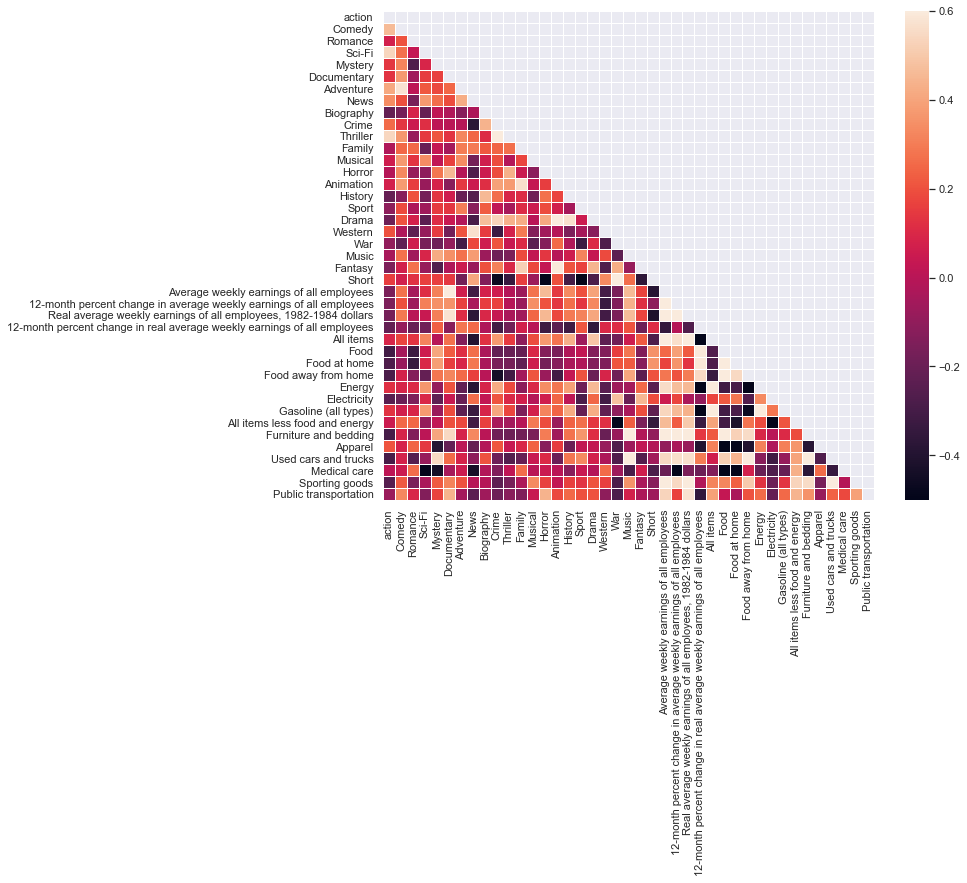

In [160]:
# Compute the correlation matrix for the count data

count_corr = df_count.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(count_corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))


sns.heatmap(count_corr, mask=mask,  vmin=-0.5, vmax=.6,
            linewidths=.5);

## Modeling the Data

In [14]:
## STEPWISE REGRESSION ANALYSIS

# import sm for OLS regression 
import statsmodels.api as sm

** Reload alldat here

In [165]:
# create a new dataframe with all data to be used in backwards stepwise regression
# with open('alldat.pkl', "rb") as fh:
#   af = pickle.load(fh)

af = pd.read_pickle('alldat.pkl')

df = af[['Month', 'Crime', 'Drama', 'Thriller', 'Animation', 'Action', 'Horror', 'Documentary',
         'Musical',  'All items', 'Food', 'Food at home', 'Energy',  
         'Gasoline (all types)', 'Public transportation', 'Average weekly earnings of all employees']]
df.columns

Index(['Month', 'Crime', 'Drama', 'Thriller', 'Animation', 'Action', 'Horror',
       'Documentary', 'Musical', 'All items', 'Food', 'Food at home', 'Energy',
       'Gasoline (all types)', 'Public transportation',
       'Average weekly earnings of all employees'],
      dtype='object')

In [166]:
# Backward stepwise regression
def stepwise(x_in, x_col, y_out, y_col):
    for val in y_col:
        xval = x_in.copy()
        xcols = x_col.copy()
        max_aic = 10000000000.0
        while True:
            X = sm.add_constant(xval)
            y = y_out[val]

            f = sm.OLS(y, X).fit()
            model = f.summary()
            aic = f.aic

            if len(f.pvalues) == 1:
                break
                
            max_value = max(f.pvalues[1:])
            maxindex = list(f.pvalues).index(max_value)-1

            if aic < max_aic and max_value > 0.05:
                xval = xval.drop(columns=[xcols[maxindex]])
                xcols = xcols[0:maxindex]+xcols[maxindex+1:]


            elif aic < max_aic and max_value <= 0.05:
                print('\n\nfinal model:')
                print(model)
                break


            else:
                print('\n\nfinal model:')
                print(model)
                break

In [167]:
x = af[['Music', 'Short', 'Family', 'Horror', 'Crime', 'Documentary',
       'News', 'Musical', 'History', 'Western', 'War', 'Comedy', 'Thriller',
       'Action', 'Romance', 'Biography', 'Sport', 'Sci-Fi', 'Drama', 'Fantasy',
       'Animation', 'Mystery', 'Adventure', 'Film-Noir', 'Adult']]

xs = ['Music', 'Short', 'Family', 'Horror', 'Crime', 'Documentary',
       'News', 'Musical', 'History', 'Western', 'War', 'Comedy', 'Thriller',
       'Action', 'Romance', 'Biography', 'Sport', 'Sci-Fi', 'Drama', 'Fantasy',
       'Animation', 'Mystery', 'Adventure', 'Film-Noir', 'Adult']


y = af[['All items',
       'Food', 'Food at home', 'Food away from home', 'Energy', 'Electricity',
       'Gasoline (all types)', 'All items less food and energy',
       'Furniture and bedding', 'Apparel', 'Used cars and trucks',
       'Medical care', 'Sporting goods', 'Public transportation',
       'Average weekly earnings of all employees',
       '12-month percent change in average weekly earnings of all employees',
       'Real average weekly earnings of all employees, 1982-1984 dollars',
       '12-month percent change in real average weekly earnings of all employees']]


ys = ['All items',
       'Food', 'Food at home', 'Food away from home', 'Energy', 'Electricity',
       'Gasoline (all types)', 'All items less food and energy',
       'Furniture and bedding', 'Apparel', 'Used cars and trucks',
       'Medical care', 'Sporting goods', 'Public transportation',
       'Average weekly earnings of all employees',
       '12-month percent change in average weekly earnings of all employees',
       'Real average weekly earnings of all employees, 1982-1984 dollars',
       '12-month percent change in real average weekly earnings of all employees']

                

# stepwise(x,xs,y,ys)
stepwise(y,ys,x,xs)



final model:
                            OLS Regression Results                            
Dep. Variable:                  Music   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     7.283
Date:                Fri, 20 Aug 2021   Prob (F-statistic):            0.00152
Time:                        15:21:14   Log-Likelihood:                -1157.1
No. Observations:                  60   AIC:                             2320.
Df Residuals:                      57   BIC:                             2327.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const            

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


final model:
                            OLS Regression Results                            
Dep. Variable:            Documentary   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     7.433
Date:                Fri, 20 Aug 2021   Prob (F-statistic):            0.00135
Time:                        15:21:15   Log-Likelihood:                -1008.7
No. Observations:                  60   AIC:                             2023.
Df Residuals:                      57   BIC:                             2030.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                                       coef    std err          t      



final model:
                            OLS Regression Results                            
Dep. Variable:                 Comedy   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     4.942
Date:                Fri, 20 Aug 2021   Prob (F-statistic):             0.0301
Time:                        15:21:16   Log-Likelihood:                -1214.5
No. Observations:                  60   AIC:                             2433.
Df Residuals:                      58   BIC:                             2437.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.637e+08   2.08e+07  



final model:
                            OLS Regression Results                            
Dep. Variable:                 Sci-Fi   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     5.421
Date:                Fri, 20 Aug 2021   Prob (F-statistic):            0.00241
Time:                        15:21:17   Log-Likelihood:                -1230.9
No. Observations:                  60   AIC:                             2470.
Df Residuals:                      56   BIC:                             2478.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const          



final model:
                            OLS Regression Results                            
Dep. Variable:              Film-Noir   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     4.097
Date:                Fri, 20 Aug 2021   Prob (F-statistic):             0.0476
Time:                        15:21:18   Log-Likelihood:                -716.38
No. Observations:                  60   AIC:                             1437.
Df Residuals:                      58   BIC:                             1441.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.043e+04   5559.491     

In [168]:
## Vector Autoregression

# modules for VAR
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [169]:
# first we do grangers causation matrix to see which variables to consider in model

from statsmodels.tsa.stattools import grangercausalitytests

maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df



# create a new df to use for grangers test
test = df.copy()
test.set_index('Month', inplace=True)

# generate the causation matrix
gcm = grangers_causation_matrix(test, variables = test.columns)


In [170]:
# save causation matrix
gcm.to_csv('gcm.csv')

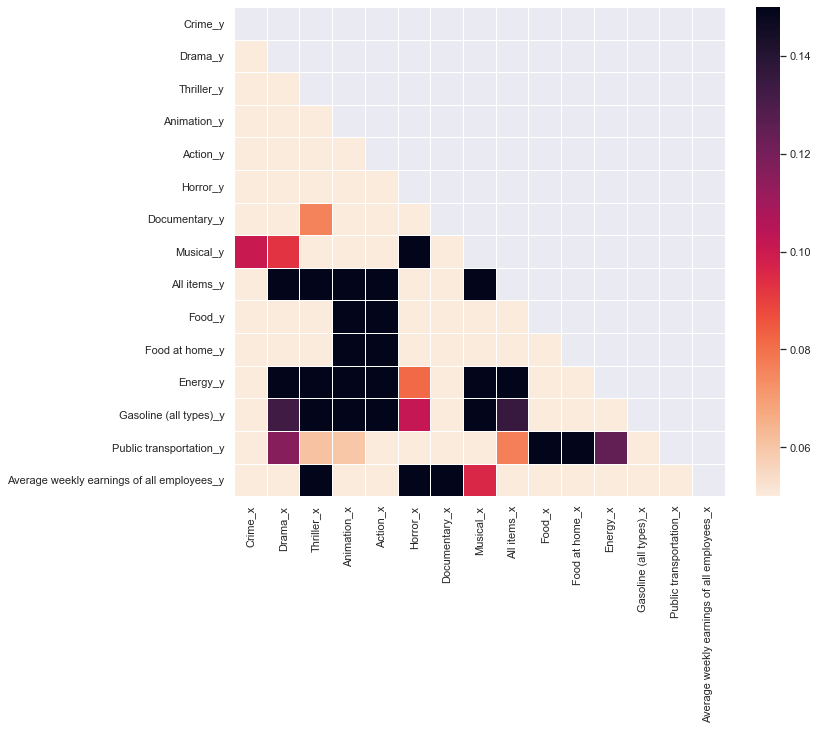

In [171]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(gcm, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


sns.heatmap(gcm, vmin=0.05, mask=mask, vmax=.15,cmap=sns.cm.rocket_r,
            linewidths=.5);

# here we want to look for lightest cells (p <0.05)

In [172]:
# next do cointegration test is to confirm which to keep

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

        
test = df.reset_index()
test = test.drop(columns=['Month', 'index', 'Musical', 'Documentary'])
test
cointegration_test(test)

# want to choose variable where value is True


Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Crime  ::  nan       > nan       =>   False
Drama  ::  nan       > 311.1288  =>   False
Thriller ::  3165.68   > 263.2603  =>   True
Animation ::  2410.3    > 219.4051  =>   True
Action ::  1782.62   > 179.5199  =>   True
Horror ::  1324.31   > 143.6691  =>   True
All items ::  917.09    > 111.7797  =>   True
Food   ::  608.94    > 83.9383   =>   True
Food at home ::  359.01    > 60.0627   =>   True
Energy ::  186.04    > 40.1749   =>   True
Gasoline (all types) ::  93.05     > 24.2761   =>   True
Public transportation ::  36.3      > 12.3212   =>   True
Average weekly earnings of all employees ::  9.94      > 4.1296    =>   True


/Users/shelleysims/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/vector_ar/vecm.py:577: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  warnings.warn("Critical values are only available for time series "
/Users/shelleysims/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/vector_ar/vecm.py:650: RuntimeWarning: invalid value encountered in log
  tmp = np.log(iota - a)[i:]
/Users/shelleysims/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/vector_ar/vecm.py:652: RuntimeWarning: invalid value encountered in log
  lr2[i] = -t * np.log(1-a[i])


In [173]:
#generate our raw data set which is the variables from above that were "True"
raw = df.set_index('Month')
raw = raw[['Thriller', 'Animation', 'Action', 'Horror', 'All items', 
             'Food', 'Food at home', 'Energy', 'Gasoline (all types)', 'Public transportation']]
raw

,Thriller,Animation,Action,Horror,All items,Food,Food at home,Energy,Gasoline (all types),Public transportation
Month,,,,,,,,,,
2015-01-01,236170777,79476683,437648575,26149007,-0.1,3.2,3.3,-19.6,-35.4,-1.8
2015-02-01,295058851,162163710,375663060,8478090,0.0,3.0,2.9,-18.8,-32.8,-1.9
2015-03-01,240864736,89926719,239011408,22254918,-0.1,2.3,1.9,-18.3,-29.2,-3.3
2015-04-01,418681880,97270366,424271339,36005673,-0.2,2.0,1.3,-19.4,-31.7,-4.7
2015-05-01,260164543,17094382,749052069,45282366,0.0,1.6,0.6,-16.3,-25.0,-4.1
2015-06-01,182684741,205738057,784637762,58912266,0.1,1.8,1.0,-15.0,-23.3,-3.2
2015-07-01,158478527,406283840,468455544,25313337,0.2,1.6,0.9,-14.8,-22.3,-3.1
2015-08-01,240530827,89830056,409916346,20310243,0.2,1.6,0.8,-15.0,-23.3,-2.9
2015-09-01,271770710,84884969,193027262,122913338,0.0,1.6,0.8,-18.4,-29.6,-2.9


In [174]:
# split into test/train sets

split = int(round(0.7*(len(raw)), 0))
split

train = raw[0:split]
test = raw[split:]

In [175]:
# adfuller test for stationary series

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [176]:
# in this case, one of the series was non-stiationary, so I differenced once and then it was stationary
diff = train.diff().dropna()

for name, column in diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Thriller" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.9879
 No. Lags Chosen       = 4
 Critical value 1%     = -3.627
 Critical value 5%     = -2.946
 Critical value 10%    = -2.612
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Animation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9454
 No. Lags Chosen       = 10
 Critical value 1%     = -3.67
 Critical value 5%     = -2.964
 Critical value 10%    = -2.621
 => P-Value = 0.0403. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Action" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

In [177]:
# test different VAR model order sizes to see which has the best accuracy (based on AIC)
model = VAR(diff)
for i in range(1,10):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print()

Lag Order = 1
AIC :  139.86880167103948
BIC :  144.51322016985281

Lag Order = 2
AIC :  139.74973386230806
BIC :  148.70737349531385

Lag Order = 3
AIC :  58.20855242195371
BIC :  71.56780793551107

Lag Order = 4
AIC :  -138.46753199190695
BIC :  -120.61681998693041

Lag Order = 5
AIC :  -157.0956760403393
BIC :  -134.66249107887774

Lag Order = 6
AIC :  -170.77071126564493
BIC :  -143.66321647968658

Lag Order = 7
AIC :  -195.5458917016204
BIC :  -163.67189251110645

Lag Order = 8
AIC :  -241.0701094651237
BIC :  -204.33765113821917

Lag Order = 9
AIC :  -463.0717324611925
BIC :  -421.38986772532525



/Users/shelleysims/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [178]:
# best accuracy at 3, show model summary
fitted = model.fit(3)
fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 20, Aug, 2021
Time:                     15:22:35
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    71.5678
Nobs:                     38.0000    HQIC:                   62.9617
Log likelihood:          -1335.16    FPE:                1.35303e+28
AIC:                      58.2086    Det(Omega_mle):     3.46497e+25
--------------------------------------------------------------------
Results for equation Thriller
                                 coefficient        std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                        -5351803.227464   22149314.363763           -0.242           0.809
L1.Thriller                        -0.486860          0.199702           -2.438           0.0

In [179]:
# perform durbin watson test to make sure there isn't major collinearity between residuals

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(fitted.resid)

for col, val in zip(diff.columns, out):
    print(col, ':', round(val, 2))

Thriller : 1.58
Animation : 1.82
Action : 2.23
Horror : 1.89
All items : 1.7
Food : 1.94
Food at home : 1.94
Energy : 1.66
Gasoline (all types) : 1.72
Public transportation : 1.45


In [180]:
# take the most recent 3 observations from training data to fit forecast

lo = fitted.k_ar

forecast_in = diff.values[-lo:]
forecast_in

array([[-1.34708847e+08, -1.85165530e+07,  1.95774590e+07,
         1.39130238e+08,  1.00000000e-01,  1.00000000e-01,
         1.00000000e-01,  9.00000000e-01,  2.30000000e+00,
        -9.00000000e-01],
       [-5.56339300e+07, -4.19362890e+07,  2.42842736e+08,
        -1.47194584e+08,  3.00000000e-01, -2.00000000e-01,
        -4.00000000e-01,  3.80000000e+00,  8.40000000e+00,
         2.00000000e-01],
       [ 1.91268950e+08,  4.19453861e+08,  3.51337453e+08,
         3.40244500e+06,  1.00000000e-01,  2.00000000e-01,
         3.00000000e-01,  3.00000000e-01,  2.50000000e+00,
         1.00000000e-01]])

In [181]:
# forecast the last 30% of data to compare with test data
s = len(raw) - split
fc = fitted.forecast(y=forecast_in, steps=s)
df_forecast = pd.DataFrame(fc, index=raw.index[split:], columns=raw.columns + '_1d')
df_forecast.round(2)

,Thriller_1d,Animation_1d,Action_1d,Horror_1d,All items_1d,Food_1d,Food at home_1d,Energy_1d,Gasoline (all types)_1d,Public transportation_1d
Month,,,,,,,,,,
2018-07-01,1.647105e+07,-1.759027e+08,-3.063324e+08,8.626375e+07,0.21,-0.25,-0.46,1.94,3.47,1.30
2018-08-01,8.176741e+07,-2.469580e+08,-1.908856e+08,7.096596e+07,0.39,0.13,0.04,3.89,7.88,0.92
2018-09-01,-2.773569e+08,-1.404046e+08,1.387755e+08,-5.291460e+07,-0.62,-0.04,0.03,-7.79,-17.35,-0.12
2018-10-01,2.302850e+08,4.392092e+08,2.440917e+07,-9.130617e+07,0.25,-0.04,-0.07,4.00,6.91,-1.29
2018-11-01,-1.892509e+08,-1.092597e+08,3.938531e+08,-1.192349e+08,-0.19,-0.14,-0.11,-2.26,-5.20,-0.99
2018-12-01,6.375074e+07,-2.123019e+07,-1.249758e+08,1.538574e+08,0.37,-0.05,-0.19,2.91,7.35,-0.35
2019-01-01,7.528604e+07,-1.336562e+08,-3.522981e+08,1.038609e+08,0.31,-0.05,-0.02,4.40,9.34,1.76
2019-02-01,1.590689e+08,1.436152e+08,1.111023e+08,-6.841359e+07,-0.06,0.01,-0.00,-0.70,-1.85,0.27
2019-03-01,-3.125794e+08,-1.061787e+08,4.551777e+06,7.356475e+06,0.29,-0.05,-0.05,2.67,4.96,0.13


In [182]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

# invert results to get final values
df_results = invert_transformation(diff, df_forecast, second_diff=False)        
df_results

,Thriller_1d,Animation_1d,Action_1d,Horror_1d,All items_1d,Food_1d,Food at home_1d,Energy_1d,Gasoline (all types)_1d,Public transportation_1d,Thriller_forecast,Animation_forecast,Action_forecast,Horror_forecast,All items_forecast,Food_forecast,Food at home_forecast,Energy_forecast,Gasoline (all types)_forecast,Public transportation_forecast
Month,,,,,,,,,,,,,,,,,,,,
2018-07-01,1.647105e+07,-1.759027e+08,-3.063324e+08,8.626375e+07,0.210910,-0.249035,-0.455415,1.941274,3.472159,1.304202,2.077400e+08,2.435512e+08,4.500502e+07,8.966619e+07,0.310910,-0.049035,-0.155415,2.241274,5.972159,1.404202
2018-08-01,8.176741e+07,-2.469580e+08,-1.908856e+08,7.096596e+07,0.386542,0.128418,0.042155,3.893720,7.882198,0.915759,2.895074e+08,-3.406764e+06,-1.458805e+08,1.606322e+08,0.697452,0.079383,-0.113260,6.134994,13.854357,2.319961
2018-09-01,-2.773569e+08,-1.404046e+08,1.387755e+08,-5.291460e+07,-0.616775,-0.035683,0.033399,-7.789917,-17.350091,-0.122702,1.215054e+07,-1.438113e+08,-7.105070e+06,1.077176e+08,0.080677,0.043701,-0.079861,-1.654923,-3.495734,2.197260
2018-10-01,2.302850e+08,4.392092e+08,2.440917e+07,-9.130617e+07,0.251476,-0.036929,-0.068136,3.998467,6.914845,-1.293942,2.424356e+08,2.953978e+08,1.730410e+07,1.641139e+07,0.332153,0.006771,-0.147997,2.343543,3.419111,0.903317
2018-11-01,-1.892509e+08,-1.092597e+08,3.938531e+08,-1.192349e+08,-0.186949,-0.137555,-0.106740,-2.259339,-5.196781,-0.987943,5.318473e+07,1.861381e+08,4.111572e+08,-1.028235e+08,0.145204,-0.130784,-0.254738,0.084204,-1.777670,-0.084625
2018-12-01,6.375074e+07,-2.123019e+07,-1.249758e+08,1.538574e+08,0.367020,-0.050629,-0.193308,2.907791,7.348092,-0.345843,1.169355e+08,1.649079e+08,2.861814e+08,5.103391e+07,0.512224,-0.181413,-0.448046,2.991995,5.570423,-0.430468
2019-01-01,7.528604e+07,-1.336562e+08,-3.522981e+08,1.038609e+08,0.308959,-0.050816,-0.024087,4.398364,9.340392,1.757850,1.922215e+08,3.125176e+07,-6.611668e+07,1.548949e+08,0.821183,-0.232229,-0.472133,7.390359,14.910815,1.327382
2019-02-01,1.590689e+08,1.436152e+08,1.111023e+08,-6.841359e+07,-0.064310,0.006598,-0.003314,-0.704319,-1.851398,0.266468,3.512904e+08,1.748670e+08,4.498559e+07,8.648126e+07,0.756873,-0.225631,-0.475447,6.686039,13.059417,1.593850
2019-03-01,-3.125794e+08,-1.061787e+08,4.551777e+06,7.356475e+06,0.291977,-0.045249,-0.048964,2.666718,4.959703,0.129242,3.871103e+07,6.868831e+07,4.953737e+07,9.383773e+07,1.048851,-0.270880,-0.524411,9.352757,18.019120,1.723093


In [183]:
actual_action = df_results['Action_1d']
predict_action_group = df_results['Action_forecast']

/Users/shelleysims/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/shelleysims/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/shelleysims/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/shelleysims/opt/anaconda3/lib/python3.8/site-packages/pan

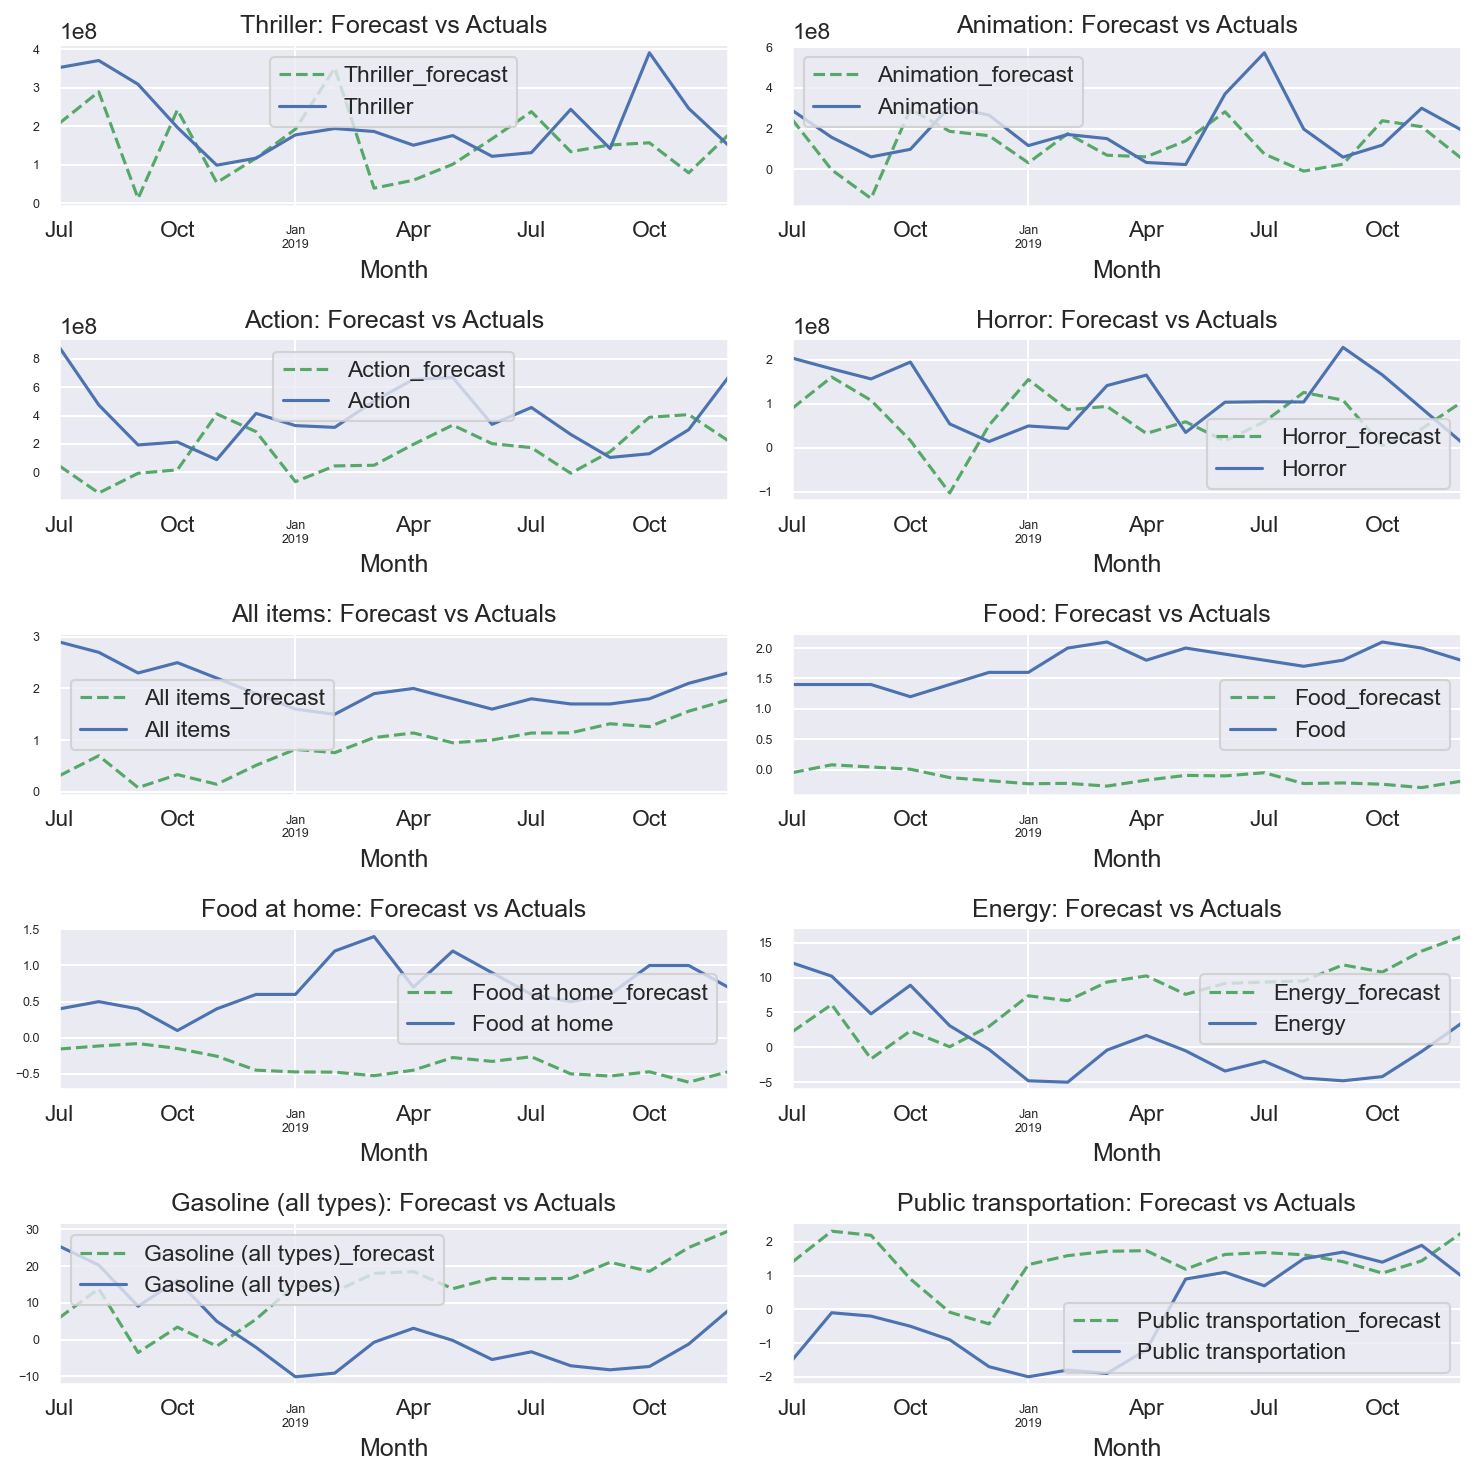

In [184]:
# plot predicted vs actual

fig, axes = plt.subplots(nrows=int(len(raw.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(raw.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(color='g', linestyle='dashed', legend=True, ax=ax).autoscale(axis='x',tight=True)
    test[col][:].plot(color='b', legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [185]:
# function to display forecast accuracy for each variable

from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})


cols = list(test.columns)

for col in cols:
    print(f'\nForecast Accuracy of: {col}')
    accuracy_prod = forecast_accuracy(df_results[col+'_forecast'].values, test[col])
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))


Forecast Accuracy of: Thriller
mape :  0.4531
me :  -54912637.233
mae :  99918797.4933
mpe :  -0.1696
rmse :  126867870.7715
corr :  0.1627
minmax :  0.4025

Forecast Accuracy of: Animation
mape :  1.0769
me :  -77241407.1195
mae :  129007009.6365
mpe :  -0.0751
rmse :  167246966.7134
corr :  0.3019
minmax :  0.7143

Forecast Accuracy of: Action
mape :  0.984
me :  -239045926.6001
mae :  319565664.8078
mpe :  -0.2823
rmse :  371622584.3363
corr :  -0.1082
minmax :  0.7433

Forecast Accuracy of: Horror
mape :  1.2489
me :  -46487654.1484
mae :  82057290.2184
mpe :  0.2231
rmse :  96423060.7301
corr :  0.1191
minmax :  0.699

Forecast Accuracy of: All items
mape :  0.5302
me :  -1.1283
mae :  1.1283
mpe :  -0.5302
rmse :  1.3322
corr :  -0.3937
minmax :  0.5302

Forecast Accuracy of: Food
mape :  1.0769
me :  -1.8642
mae :  1.8642
mpe :  -1.0769
rmse :  1.897
corr :  -0.6942
minmax :  1.0769

Forecast Accuracy of: Food at home
mape :  1.5856
me :  -1.0758
mae :  1.0758
mpe :  -1.5856
rm

<ipython-input-185-e7f3864de129>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-185-e7f3864de129>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


### Model with Action genre only and all economic factors

** Reload alldat here

In [186]:
## Testing with just Action and all economic factors so the other genre data is not factored in to the model

with open('alldat.pkl', "rb") as fh:
  af = pickle.load(fh)

df_a = af[['Month', 'Action','All items',
       'Food', 'Food at home', 'Food away from home', 'Energy', 'Electricity',
       'Gasoline (all types)', 'All items less food and energy',
       'Furniture and bedding', 'Apparel', 'Used cars and trucks',
       'Medical care', 'Sporting goods', 'Public transportation',
       'Average weekly earnings of all employees',
       '12-month percent change in average weekly earnings of all employees',
       'Real average weekly earnings of all employees, 1982-1984 dollars',
       '12-month percent change in real average weekly earnings of all employees']]

df_a.columns

Index(['Month', 'Action', 'All items', 'Food', 'Food at home',
       'Food away from home', 'Energy', 'Electricity', 'Gasoline (all types)',
       'All items less food and energy', 'Furniture and bedding', 'Apparel',
       'Used cars and trucks', 'Medical care', 'Sporting goods',
       'Public transportation', 'Average weekly earnings of all employees',
       '12-month percent change in average weekly earnings of all employees',
       'Real average weekly earnings of all employees, 1982-1984 dollars',
       '12-month percent change in real average weekly earnings of all employees'],
      dtype='object')

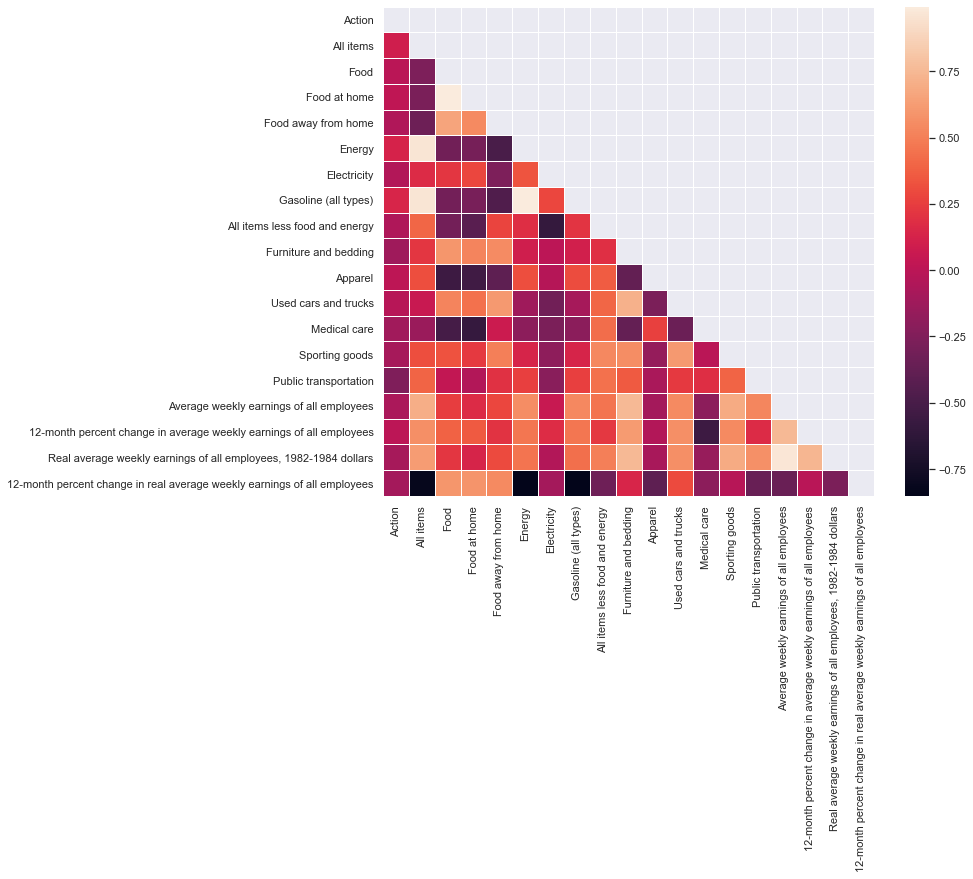

In [187]:
corr = df_a.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask,
            linewidths=.5);

In [188]:
# create a new df to use for grangers test
test = df_a.copy()
test.set_index('Month', inplace=True)

# generate the causation matrix
gcm = grangers_causation_matrix(test, variables = test.columns)

In [189]:
# save causation matrix
gcm.to_csv('gcm.csv')

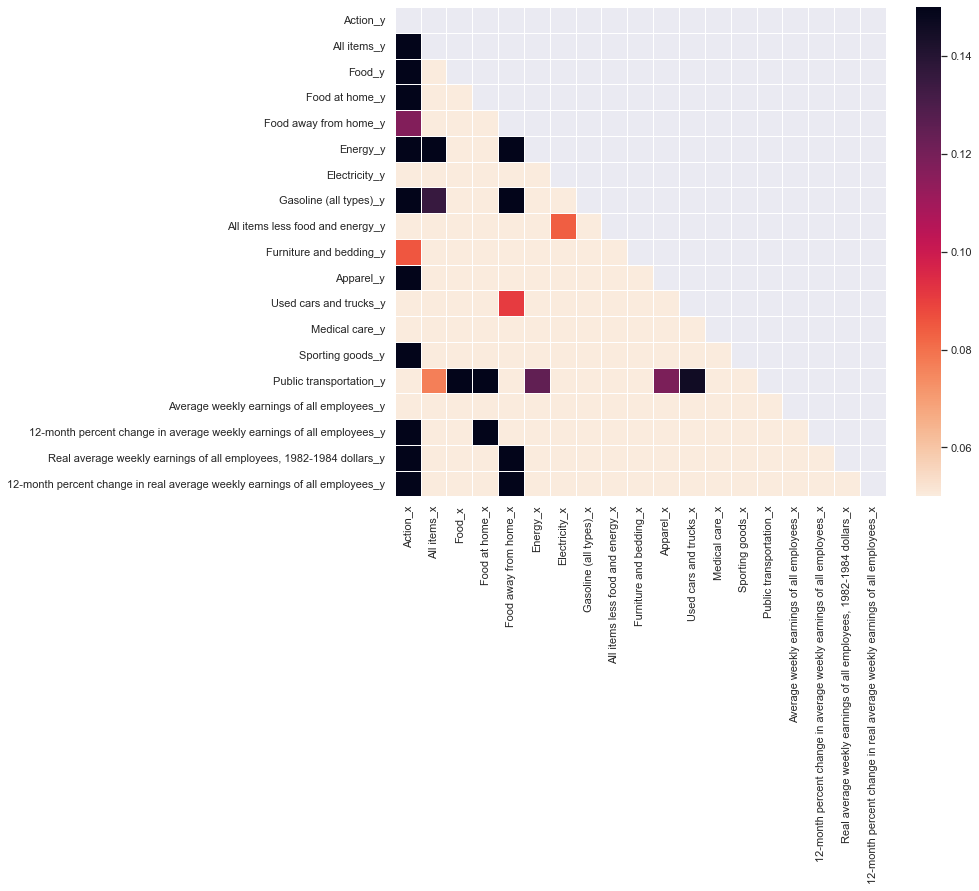

In [190]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(gcm, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


sns.heatmap(gcm, vmin=0.05, mask=mask,vmax=.15,cmap=sns.cm.rocket_r,
            linewidths=.5);

# here we want to look for lightest cells (p <0.05)

In [191]:
df_a.columns

Index(['Month', 'Action', 'All items', 'Food', 'Food at home',
       'Food away from home', 'Energy', 'Electricity', 'Gasoline (all types)',
       'All items less food and energy', 'Furniture and bedding', 'Apparel',
       'Used cars and trucks', 'Medical care', 'Sporting goods',
       'Public transportation', 'Average weekly earnings of all employees',
       '12-month percent change in average weekly earnings of all employees',
       'Real average weekly earnings of all employees, 1982-1984 dollars',
       '12-month percent change in real average weekly earnings of all employees'],
      dtype='object')

In [192]:
# Items to leave in were chosen by adding in one at a time and checking 
# what keeps the matrix positive definite in the next section
df = df_a[['Month', 'Action', 'All items', 'Food', 'Food at home', 'Food away from home', 'Energy', 'Electricity',
           'Gasoline (all types)']]

In [193]:
# next do cointegration test is to confirm which to keep

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

        
test = df.reset_index()
test = test.drop(columns=['Month','index'])
test
cointegration_test(test)

# want to choose variable where value is True

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Action ::  3179.05   > 143.6691  =>   True
All items ::  1641.3    > 111.7797  =>   True
Food   ::  322.05    > 83.9383   =>   True
Food at home ::  212.89    > 60.0627   =>   True
Food away from home ::  119.84    > 40.1749   =>   True
Energy ::  53.89     > 24.2761   =>   True
Electricity ::  20.34     > 12.3212   =>   True
Gasoline (all types) ::  3.69      > 4.1296    =>   False


In [194]:
#generate our raw data set which is the variables from above that were "True"
raw = df.set_index('Month')
raw = raw[['Action', 'All items', 'Food', 'Food at home', 'Food away from home', 'Energy', 'Electricity']]
raw.head()

,Action,All items,Food,Food at home,Food away from home,Energy,Electricity
Month,,,,,,,
2015-01-01,437648575,-0.1,3.2,3.3,3.1,-19.6,2.5
2015-02-01,375663060,0.0,3.0,2.9,3.1,-18.8,3.2
2015-03-01,239011408,-0.1,2.3,1.9,2.9,-18.3,0.9
2015-04-01,424271339,-0.2,2.0,1.3,2.9,-19.4,3.8
2015-05-01,749052069,0.0,1.6,0.6,3.0,-16.3,0.5


In [195]:
# split into test/train sets

split = int(round(0.7*(len(raw)), 0))
split

train = raw[0:split]
test = raw[split:]

In [196]:
# adfuller test for stationary series

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [197]:
# difference data to make it stationary
diff = train.diff().dropna()

for name, column in diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Action" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9626
 No. Lags Chosen       = 9
 Critical value 1%     = -3.661
 Critical value 5%     = -2.961
 Critical value 10%    = -2.619
 => P-Value = 0.0385. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "All items" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3355
 No. Lags Chosen       = 0
 Critical value 1%     = -3.606
 Critical value 5%     = -2.937
 Critical value 10%    = -2.607
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Food" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level 

In [198]:
# test different VAR model order sizes to see which has the best accuracy (based on AIC)
model = VAR(diff)
for i in range(1,10):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print()

Lag Order = 1
AIC :  23.096937249603577
BIC :  25.46136848536309

Lag Order = 2
AIC :  22.53792994663527
BIC :  27.016749763138165

Lag Order = 3
AIC :  21.1395621391652
BIC :  27.776095523319498

Lag Order = 4
AIC :  5.009993961374774
BIC :  13.848273319936329

Lag Order = 5


/Users/shelleysims/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/shelleysims/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/vector_ar/var_model.py:716: RuntimeWarning: divide by zero encountered in true_divide
  omega = sse / df_resid
/Users/shelleysims/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/vector_ar/var_model.py:1379: RuntimeWarning: invalid value encountered in multiply
  return self.sigma_u * self.df_resid / self.nobs


ValueError: array must not contain infs or NaNs

In [199]:
# best accuracy at 4, show model summary
fitted = model.fit(4)
fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 20, Aug, 2021
Time:                     15:24:47
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    13.8483
Nobs:                     37.0000    HQIC:                   8.12590
Log likelihood:          -257.190    FPE:                    6690.97
AIC:                      5.00999    Det(Omega_mle):         116.438
--------------------------------------------------------------------
Results for equation Action
                               coefficient         std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                      -4778383.309556    46774201.606768           -0.102           0.919
L1.Action                        -0.580838           0.285325           -2.036           0.042
L1.

In [200]:
# perform durbin watson test to make sure there isn't major collinearity between residuals

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(fitted.resid)

for col, val in zip(diff.columns, out):
    print(col, ':', round(val, 2))

Action : 2.69
All items : 1.64
Food : 2.74
Food at home : 2.63
Food away from home : 2.47
Energy : 2.17
Electricity : 2.63


In [201]:
# take the most recent 3 observations from training data to fit forecast

lo = fitted.k_ar

forecast_in = diff.values[-lo:]
forecast_in

array([[-6.35645520e+07,  2.00000000e-01, -1.00000000e-01,
        -1.00000000e-01, -1.00000000e-01, -7.00000000e-01,
         0.00000000e+00],
       [ 1.95774590e+07,  1.00000000e-01,  1.00000000e-01,
         1.00000000e-01,  0.00000000e+00,  9.00000000e-01,
        -1.00000000e+00],
       [ 2.42842736e+08,  3.00000000e-01, -2.00000000e-01,
        -4.00000000e-01,  2.00000000e-01,  3.80000000e+00,
        -2.00000000e-01],
       [ 3.51337453e+08,  1.00000000e-01,  2.00000000e-01,
         3.00000000e-01,  1.00000000e-01,  3.00000000e-01,
        -1.10000000e+00]])

In [202]:
# forecast the last 30% of data to compare with test data
s = len(raw) - split
fc = fitted.forecast(y=forecast_in, steps=s)
df_forecast = pd.DataFrame(fc, index=raw.index[split:], columns=raw.columns + '_1d')
df_forecast.round(2)

,Action_1d,All items_1d,Food_1d,Food at home_1d,Food away from home_1d,Energy_1d,Electricity_1d
Month,,,,,,,
2018-07-01,-5.113715e+08,0.65,-0.02,-0.26,0.23,8.08,0.01
2018-08-01,2.152045e+08,-0.39,0.15,0.19,0.12,-5.05,-0.27
2018-09-01,-2.686148e+08,-0.52,-0.10,-0.28,0.06,-7.42,1.45
2018-10-01,3.256189e+08,-0.08,-0.02,-0.08,0.05,-0.34,-0.25
2018-11-01,2.604451e+08,-0.15,-0.44,-0.59,-0.27,-4.14,0.96
2018-12-01,-6.652726e+07,0.59,-0.33,-0.43,-0.07,7.64,-1.77
2019-01-01,-1.661272e+08,0.52,-0.40,-0.64,0.07,6.51,-0.44
2019-02-01,1.168670e+08,0.11,0.21,0.37,0.00,-0.75,-0.96
2019-03-01,-6.740764e+08,0.49,-0.09,-0.25,0.11,7.65,0.84


In [203]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

# invert results to get final values
df_results = invert_transformation(diff, df_forecast, second_diff=False)        
df_results

,Action_1d,All items_1d,Food_1d,Food at home_1d,Food away from home_1d,Energy_1d,Electricity_1d,Action_forecast,All items_forecast,Food_forecast,Food at home_forecast,Food away from home_forecast,Energy_forecast,Electricity_forecast
Month,,,,,,,,,,,,,,
2018-07-01,-5.113715e+08,0.647085,-0.023431,-0.262325,0.225932,8.081979,0.013067,-1.600340e+08,0.747085,0.176569,0.037675,0.325932,8.381979,-1.086933
2018-08-01,2.152045e+08,-0.391865,0.146086,0.191135,0.124991,-5.050815,-0.268662,5.517052e+07,0.355220,0.322655,0.228811,0.450923,3.331165,-1.355595
2018-09-01,-2.686148e+08,-0.518634,-0.096065,-0.284776,0.061467,-7.424671,1.449949,-2.134443e+08,-0.163414,0.226590,-0.055965,0.512390,-4.093507,0.094354
2018-10-01,3.256189e+08,-0.075820,-0.018689,-0.079190,0.045894,-0.335063,-0.253949,1.121746e+08,-0.239234,0.207901,-0.135156,0.558284,-4.428569,-0.159595
2018-11-01,2.604451e+08,-0.146774,-0.441972,-0.591018,-0.268080,-4.135530,0.960915,3.726197e+08,-0.386007,-0.234071,-0.726174,0.290204,-8.564099,0.801319
2018-12-01,-6.652726e+07,0.593480,-0.328978,-0.434630,-0.069440,7.636287,-1.768810,3.060925e+08,0.207472,-0.563049,-1.160804,0.220764,-0.927812,-0.967491
2019-01-01,-1.661272e+08,0.522908,-0.400747,-0.644995,0.066568,6.512966,-0.435688,1.399652e+08,0.730381,-0.963796,-1.805799,0.287332,5.585154,-1.403179
2019-02-01,1.168670e+08,0.114324,0.210360,0.372496,0.000590,-0.752904,-0.955543,2.568323e+08,0.844704,-0.753436,-1.433303,0.287922,4.832251,-2.358722
2019-03-01,-6.740764e+08,0.493941,-0.086515,-0.252962,0.114012,7.648374,0.843291,-4.172441e+08,1.338645,-0.839951,-1.686265,0.401934,12.480625,-1.515431


In [204]:
predict_action_alone = df_results['Action_forecast']

/Users/shelleysims/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/shelleysims/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/shelleysims/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/shelleysims/opt/anaconda3/lib/python3.8/site-packages/pan

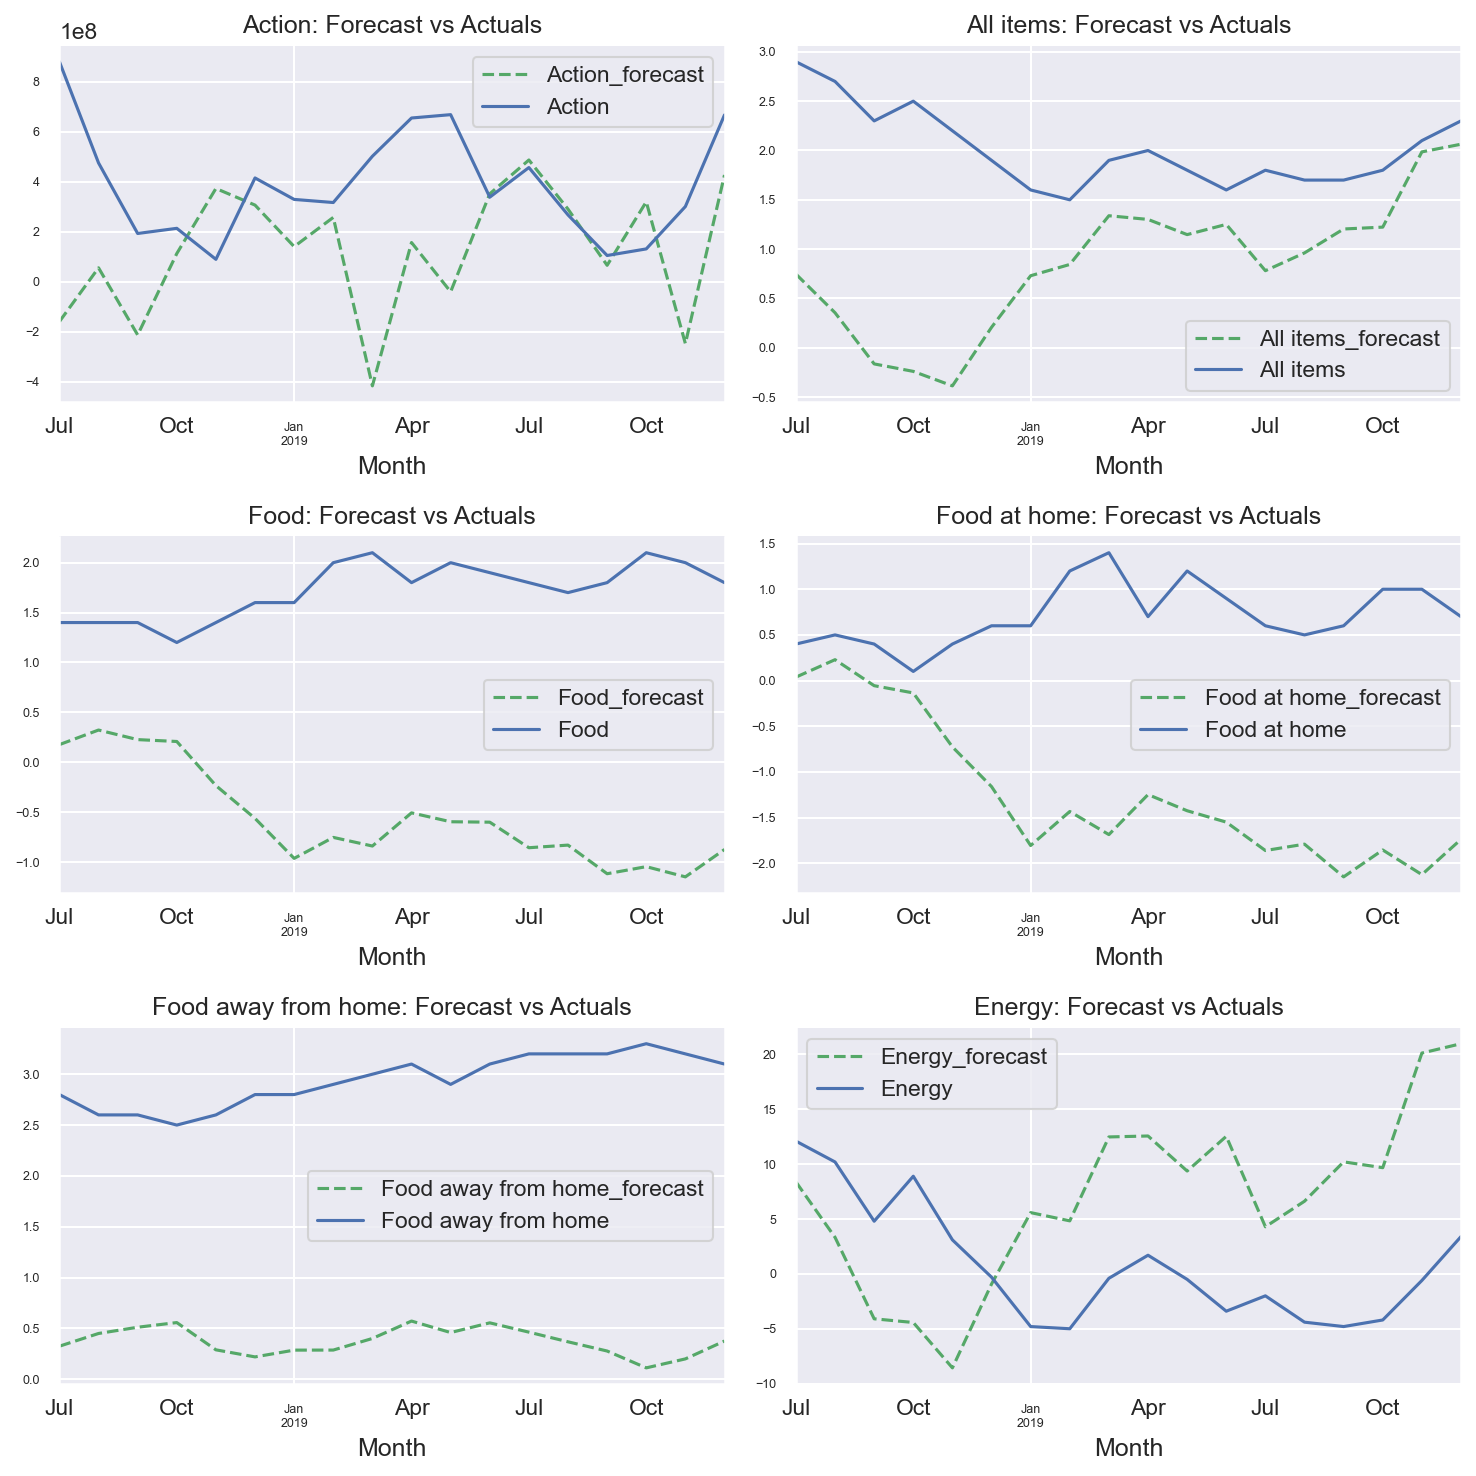

In [205]:
# plot predicted vs actual

fig, axes = plt.subplots(nrows=int(len(raw.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(raw.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(color='g', linestyle='dashed', legend=True, ax=ax).autoscale(axis='x',tight=True)
    test[col][:].plot(color='b', legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [206]:
# function to display forecast accuracy for each variable

from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})


cols = list(test.columns)

for col in cols:
    print(f'\nForecast Accuracy of: {col}')
    accuracy_prod = forecast_accuracy(df_results[col+'_forecast'].values, test[col])
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))


Forecast Accuracy of: Action
mape :  0.9282
me :  -263276200.2599
mae :  323153664.6864
mpe :  -0.3928
rmse :  444500727.1595
corr :  -0.1866
minmax :  0.7456

Forecast Accuracy of: All items
mape :  0.5455
me :  -1.1636
mae :  1.1636
mpe :  -0.5455
rmse :  1.4534
corr :  -0.3029
minmax :  0.5455

Forecast Accuracy of: Food
mape :  1.2915
me :  -2.2778
mae :  2.2778
mpe :  -1.2915
rmse :  2.3855
corr :  -0.8007
minmax :  1.2915

Forecast Accuracy of: Food at home
mape :  2.751
me :  -1.9599
mae :  1.9599
mpe :  -2.751
rmse :  2.192
corr :  -0.5679
minmax :  2.751

Forecast Accuracy of: Food away from home
mape :  0.8708
me :  -2.5652
mae :  2.5652
mpe :  -0.8708
rmse :  2.5837
corr :  -0.2865
minmax :  0.8708

Forecast Accuracy of: Energy
mape :  7.1745
me :  6.0656
mae :  11.0768
mpe :  -5.6573
rmse :  12.0454
corr :  -0.2681
minmax :  1.2232

Forecast Accuracy of: Electricity
mape :  inf
me :  -0.813
mae :  0.9792
mpe :  -inf
rmse :  1.2061
corr :  0.1288
minmax :  inf


<ipython-input-206-e7f3864de129>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-206-e7f3864de129>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-206-e7f3864de129>:15: RuntimeWarning: divide by zero encountered in true_divide
  minmax = 1 - np.mean(mins/maxs)             # minmax


### Diebold-Mariano Test

In [132]:
# via John Tsang, Github: johntwk
# Diebold-Mariano Test

def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):  
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

In [207]:
dm_test(actual_action, predict_action_group, predict_action_alone)

dm_return(DM=-2.576332117765828, p_value=0.019616085081952932)

In [103]:
df_count = pd.read_pickle('econ_count_data.pkl')
df_count.head()

,Month,action,Comedy,Romance,Sci-Fi,Adult,Mystery,Documentary,Adventure,News,...,Energy,Electricity,Gasoline (all types),All items less food and energy,Furniture and bedding,Apparel,Used cars and trucks,Medical care,Sporting goods,Public transportation
0,2015-01-01,318,543,273,205,1.0,105,100,518,1.0,...,-19.6,2.5,-35.4,1.6,-2.2,-1.4,-4.0,2.6,-1.9,-1.8
1,2015-02-01,242,455,226,160,NaN,130,85,514,9.0,...,-18.8,3.2,-32.8,1.7,-1.5,-0.8,-2.9,2.3,-1.9,-1.9
2,2015-03-01,324,483,240,233,NaN,102,108,401,9.0,...,-18.3,0.9,-29.2,1.8,-0.7,-0.5,-1.3,2.5,-2.2,-3.3
3,2015-04-01,383,440,230,164,NaN,142,145,362,10.0,...,-19.4,3.8,-31.7,1.8,0.0,-0.8,-0.5,2.9,-2.2,-4.7
4,2015-05-01,372,483,217,204,NaN,154,137,341,2.0,...,-16.3,0.5,-25.0,1.7,-0.8,-1.5,-0.5,2.8,-2.0,-4.1


In [104]:
df_count_a = df_count[['Month', 'action',
       'All items', 'Food', 'Food at home', 'Food away from home', 'Energy',
       'Electricity', 'Gasoline (all types)', 'All items less food and energy',
       'Furniture and bedding', 'Apparel', 'Used cars and trucks',
       'Medical care', 'Sporting goods', 'Public transportation',
       'Average weekly earnings of all employees',
       '12-month percent change in average weekly earnings of all employees',
       'Real average weekly earnings of all employees, 1982-1984 dollars',
       '12-month percent change in real average weekly earnings of all employees']]

In [105]:
df_count_a.head()

,Month,action,All items,Food,Food at home,Food away from home,Energy,Electricity,Gasoline (all types),All items less food and energy,Furniture and bedding,Apparel,Used cars and trucks,Medical care,Sporting goods,Public transportation,Average weekly earnings of all employees,12-month percent change in average weekly earnings of all employees,"Real average weekly earnings of all employees, 1982-1984 dollars",12-month percent change in real average weekly earnings of all employees
0,2015-01-01,318,-0.1,3.2,3.3,3.1,-19.6,2.5,-35.4,1.6,-2.2,-1.4,-4.0,2.6,-1.9,-1.8,853.19,2.4,363.45,2.7
1,2015-02-01,242,0.0,3.0,2.9,3.1,-18.8,3.2,-32.8,1.7,-1.5,-0.8,-2.9,2.3,-1.9,-1.9,857.39,2.8,364.32,2.9
2,2015-03-01,324,-0.1,2.3,1.9,2.9,-18.3,0.9,-29.2,1.8,-0.7,-0.5,-1.3,2.5,-2.2,-3.3,856.98,2.2,363.16,2.2
3,2015-04-01,383,-0.2,2.0,1.3,2.9,-19.4,3.8,-31.7,1.8,0.0,-0.8,-0.5,2.9,-2.2,-4.7,858.71,2.3,363.52,2.4
4,2015-05-01,372,0.0,1.6,0.6,3.0,-16.3,0.5,-25.0,1.7,-0.8,-1.5,-0.5,2.8,-2.0,-4.1,861.12,2.3,363.34,2.3


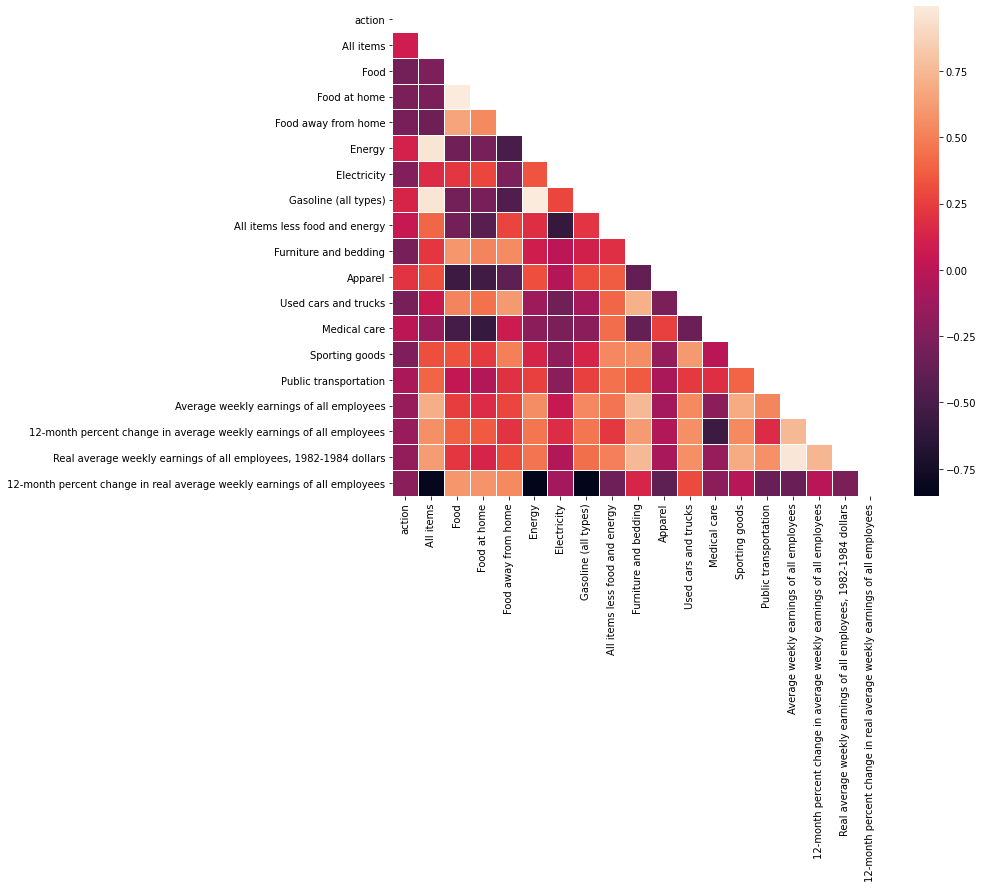

In [106]:
# Correlation matrix for action count versus econ data
corr = df_count_a.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask,
            linewidths=.5);

## Extra Visualizations and aggregates

In [114]:
## Extra visualizations

labor_v_gross = pd.read_pickle('../new_merged_data/monthly_labor_genre-daily-gross.pkl')
labor_v_count = pd.read_pickle('../new_merged_data/monthly_labor_genre-daily-count.pkl')

In [136]:
sns.set(rc={'figure.figsize':(10, 7)})
labor_v_gross_ts = labor_v_gross.set_index('Month')

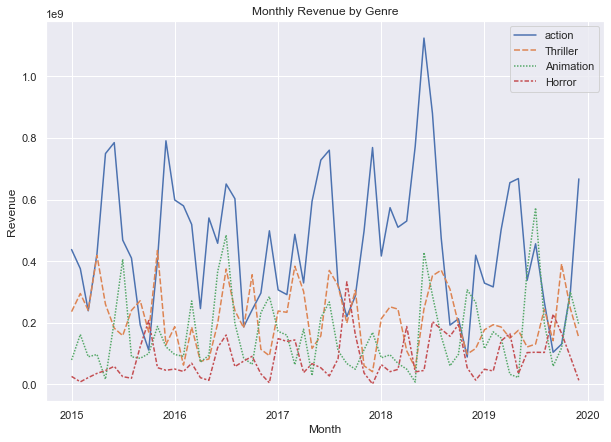

In [140]:
# select genres by gross
ax = sns.lineplot(data=labor_v_gross_ts[['action', 'Thriller', 'Animation','Horror']])
ax.set_title('Monthly Revenue by Genre')
ax.set(xlabel='Month', ylabel='Revenue')
plt.show()

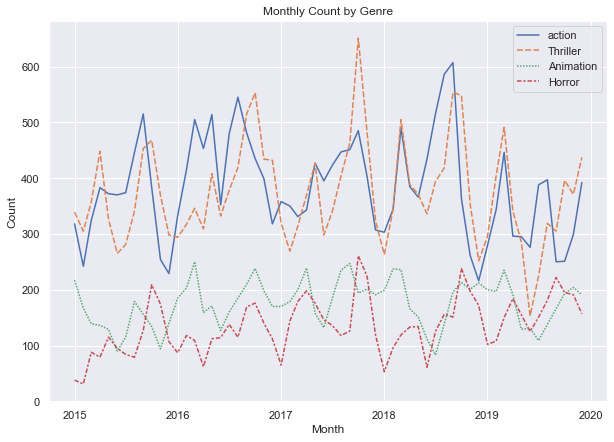

In [141]:
# Select genres by count
labor_v_count_ts = labor_v_count.set_index('Month')
ax = sns.lineplot(data=labor_v_count_ts[['action', 'Thriller', 'Animation','Horror']])
ax.set_title('Monthly Count by Genre')
ax.set(xlabel='Month', ylabel='Count')
plt.show()

In [118]:
gross_v_count_action = pd.merge(labor_v_gross_ts['action'], labor_v_count_ts['action'], on='Month')
gross_v_count_action.rename(columns={'action_x':'gross', 'action_y':'count'}, inplace=True)
gross_v_count_action.head()

,gross,count
Month,,
2015-01-01,437648575,318
2015-02-01,375663060,242
2015-03-01,239011408,324
2015-04-01,424271339,383
2015-05-01,749057138,372


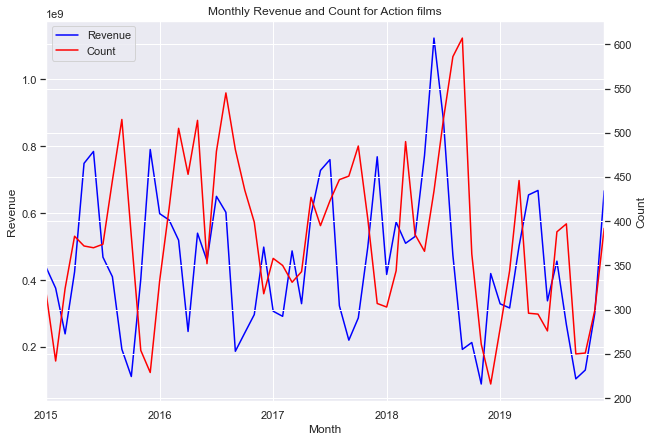

In [142]:
plt.figure(figsize=(10,7))
plt.xlabel('Monthly numbers')
ax1 = gross_v_count_action.gross.plot(color='blue', grid=True, label='Revenue')
ax2 = gross_v_count_action['count'].plot(color='red', grid=True, secondary_y=True, label='Count')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
ax1.set_ylabel('Revenue')
ax2.set_ylabel('Count')
ax1.set_title('Monthly Revenue and Count for Action films')
plt.show()

In [222]:
## Checking where the spike in action films comes from in summer 2018
movie = pd.read_pickle('clean-boxofficemojo-daily_gross.pkl')
mask = (movie['Date'] > '2018-03-01') & (movie['Date'] < '2018-08-01')
temp = movie.loc[mask].groupby('Movie').agg({'Daily':'sum', 'Action':'sum'})
maxRev = temp['Daily'].max()
print(temp.loc[temp['Daily']== maxRev])
top_gross_summer = temp.sort_values('Daily', ascending=False).head(10)
top_gross_summer

                            Daily  Action
Movie                                    
Avengers: Infinity War  677698471      96


,Daily,Action
Movie,,
Avengers: Infinity War,677698471,96
Incredibles 2,575696190,47
Jurassic World: Fallen Kingdom,399764130,40
Deadpool 2,317764929,75
Black Panther,264555995,152
Solo: A Star Wars Story,212783601,68
A Quiet Place,187993552,0
Ant-Man and the Wasp,186677725,26
Ocean's Eight,137541431,54


In [221]:
top_movies = top_gross_summer.index.tolist()
top_total = movie.loc[movie['Movie'].isin(top_movies)]
top_total[['Movie', 'Action']].groupby('Movie').agg({'Action':'sum'})

,Action
Movie,
A Quiet Place,0
Ant-Man and the Wasp,119
Avengers: Infinity War,140
Black Panther,175
Deadpool 2,126
Incredibles 2,182
Jurassic World: Fallen Kingdom,105
Ocean's Eight,105
Ready Player One,99
